### Imports

In [3]:
import torch
import torch.nn as nn
import timm
from torchvision import models
from torchvision.models import ResNet34_Weights
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Base Model

In [4]:
class BaseModel(nn.Module):
    def __init__(self, backbone: nn.Module, num_classes=5):
        super().__init__()
        self.backbone = backbone

        dummy = torch.randn(1, 3, 224, 224).to(device)
        with torch.no_grad():
            feats = self.backbone(dummy)
            if feats.ndim == 4:
                feats = nn.AdaptiveAvgPool2d((1, 1))(feats).view(feats.size(0), -1)

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(feats.shape[1]),
            nn.Dropout(0.3),
            nn.Linear(feats.shape[1], num_classes)
        ).to(device)

    def forward(self, x):
        feats = self.backbone(x)
        if feats.ndim == 4:
            feats = nn.AdaptiveAvgPool2d((1, 1))(feats).view(feats.size(0), -1)
        logits = self.classifier(feats)
        return logits, feats

### LogitWrapper Utility Class
A simple wrapper that extracts only the logits from a model that returns multiple outputs.

In [ ]:
class LogitWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        logits, _ = self.m(x)
        return logits

### Load and Prepare ResNet34 Explainability Model
Initializes a ResNet34 backbone, wraps it in the BaseModel class, loads trained weights, and sets the model to evaluation mode.

In [5]:
resnet34_backbone = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
resnet34_backbone.fc = nn.Identity()                     # important!
resnet34_backbone = resnet34_backbone.to(device)

resnet34_model = BaseModel(resnet34_backbone, num_classes=5).to(device)

ckpt_res = torch.load("new_saved_models/best_resnet.pth", map_location=device)
if "model" in ckpt_res:
    resnet34_model.load_state_dict(ckpt_res["model"])
else:
    resnet34_model.load_state_dict(ckpt_res)

resnet34_model.eval()

print("Loaded ResNet34 Explainability Model")

Loaded ResNet34 Explainability Model


### Load and Prepare ConvNeXt-Tiny Explainability Model

Initializes a ConvNeXt-Tiny backbone, wraps it in BaseModel, loads the checkpoint, and sets the model to eval mode.

In [6]:
convnext_backbone = timm.create_model(
    "convnext_tiny_in22k",
    pretrained=True,
    num_classes=0
).to(device)

convnext_model = BaseModel(convnext_backbone, num_classes=5).to(device)

ckpt_cn = torch.load("new_saved_models/best_convnext.pth", map_location=device)
if "model" in ckpt_cn:
    convnext_model.load_state_dict(ckpt_cn["model"])
else:
    convnext_model.load_state_dict(ckpt_cn)

convnext_model.eval()

print("Loaded ConvNeXt-Tiny Explainability Model")

Loaded ConvNeXt-Tiny Explainability Model


### Load and Prepare ViT-B/16 Explainability Model

Initializes a ViT-B/16 backbone, wraps it in BaseModel, loads the trained checkpoint, and sets the model to evaluation mode.

In [7]:
vit_backbone = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=0
).to(device)

vit_model = BaseModel(vit_backbone, num_classes=5).to(device)

ckpt_vit = torch.load("new_saved_models/best_vit.pth", map_location=device)
if "model" in ckpt_vit:
    vit_model.load_state_dict(ckpt_vit["model"])
else:
    vit_model.load_state_dict(ckpt_vit)

vit_model.eval()

print("Loaded ViT-B/16 Explainability Model")

Loaded ViT-B/16 Explainability Model


In [12]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from skimage.filters import threshold_otsu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### IoU Computation Function
Computes the intersection-over-union score between a predicted mask and the ground-truth mask.

In [22]:
def compute_iou(pred_mask: np.ndarray, gt_mask: np.ndarray) -> float:
    inter = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return float(inter) / (union + 1e-8)

### Deletion AUC Metric
Implements the deletion metric by progressively removing the most salient pixels and tracking how the model’s confidence decreases to compute the AUC.

In [ ]:
def deletion_auc(model, base_conf, orig, cam_flat, cls, steps=50):
    H, W = cam_flat.shape
    flat_inds = np.argsort(cam_flat.ravel())[::-1]
    fracs = np.linspace(0, 1, steps)
    scores = []

    for frac in fracs:
        n = int(frac * H * W)

        # create mask: keep all except top-n salient pixels
        mask = np.ones_like(cam_flat.ravel(), dtype=bool)
        mask[flat_inds[:n]] = False
        mask2d = mask.reshape(H, W)

        # upsample mask to original size
        m_big = cv2.resize(mask2d.astype(np.uint8),
                           (orig.shape[1], orig.shape[0]),
                           interpolation=cv2.INTER_NEAREST).astype(bool)

        # apply mask
        inp = orig.copy()
        inp[~m_big] = 0

        # preprocess
        x = (cv2.resize(inp, (224, 224)) / 255.0 - mean) / std
        t = torch.from_numpy(x.transpose(2, 0, 1)).unsqueeze(0).to(device)

        # forward pass — unpack logits
        with torch.no_grad():
            logits, _ = model(t)
            conf = F.softmax(logits, dim=1)[0, cls].item()

        scores.append(conf)

    return float(np.trapz(scores, fracs))

### Insertion AUC Metric
Implements the insertion metric by progressively revealing the most salient pixels and measuring how the model's confidence changes to compute the AUC.

In [ ]:
def insertion_auc(model, base_conf, orig, cam_flat, cls, steps=50):
    H, W = cam_flat.shape
    flat_inds = np.argsort(cam_flat.ravel())[::-1]
    fracs = np.linspace(0, 1, steps)
    scores = []

    blank = np.zeros_like(orig)

    for frac in fracs:
        n = int(frac * H * W)

        # create mask: insert top-n salient pixels only
        mask = np.zeros_like(cam_flat.ravel(), dtype=bool)
        mask[flat_inds[:n]] = True
        mask2d = mask.reshape(H, W)

        # upsample mask
        m_big = cv2.resize(mask2d.astype(np.uint8),
                           (orig.shape[1], orig.shape[0]),
                           interpolation=cv2.INTER_NEAREST).astype(bool)

        # construct partially revealed image
        inp = blank.copy()
        inp[m_big] = orig[m_big]

        # preprocess
        x = (cv2.resize(inp, (224, 224)) / 255.0 - mean) / std
        t = torch.from_numpy(x.transpose(2, 0, 1)).unsqueeze(0).to(device)

        # forward pass — unpack logits
        with torch.no_grad():
            logits, _ = model(t)
            conf = F.softmax(logits, dim=1)[0, cls].item()

        scores.append(conf)

    return float(np.trapz(scores, fracs))

### Register Feature Hooks for Backbones
Selects the final convolutional or projection layers from each backbone to attach hooks for generating saliency and attention-based explanations.

In [23]:
hook_res = resnet34_backbone.layer4[-1].conv2
hook_cn = convnext_backbone.stages[-1].blocks[-1].conv_dw
hook_vit = vit_backbone.patch_embed.proj

### Initialize GradCAM for All Models
Creates a mapping of model names to their hooks and initializes GradCAM instances for each backbone.

In [24]:
models_map = {
    "ResNet-34": (resnet34_model, hook_res),
    "ConvNeXt-Tiny": (convnext_model, hook_cn),
    "ViT-B16": (vit_model, hook_vit),
}

cams = {
    name: GradCAM(model=mdl, target_layers=[layer])
    for name, (mdl, layer) in models_map.items()
}

### Load Test Image and Prepare Ground-Truth Mask
Reads the input image, initializes an empty ground-truth mask, and prepares a visualization overlay.

In [25]:
img = cv2.cvtColor(cv2.imread("Dataset/test_images/e4dcca36ceb4.png"), cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

gt_mask = np.zeros((H, W), dtype=bool)

overlay_gt = np.zeros_like(img)
overlay_gt[..., 0] = gt_mask.astype(np.uint8) * 255

### Image Normalization and Tensor Preparation
Normalizes the input image using ImageNet statistics, resizes it to 224×224, and converts it into a model-ready tensor.

In [26]:
mean = np.array([0.485, 0.456, 0.406], np.float32)
std = np.array([0.229, 0.224, 0.225], np.float32)

img224 = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0
x = (img224 - mean) / std
tensor = torch.from_numpy(x.transpose(2, 0, 1)).unsqueeze(0).to(device)

### Import Libraries and Define Utility Functions
Includes essential packages and helper metrics such as IoU, deletion AUC, and insertion AUC.

In [89]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import models
from torchvision.models import ResNet34_Weights
import timm

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from skimage.filters import threshold_otsu
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Initialization and Hook Setup
Load three backbone models (ResNet-34, ConvNeXt-Tiny, ViT-B/16), remove their classifier heads, register hook layers, and wrap each in `BaseModel`.


In [90]:
# --- ResNet-34 ---
res = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
res.fc = nn.Identity()
hook_res = res.layer4[-1].conv2
m_res = BaseModel(res, "new_saved_models/best_resnet.pth").to(device)

# --- ConvNeXt-Tiny ---
cn = timm.create_model("convnext_tiny", pretrained=True)
cn.head.fc = nn.Identity()      # Only remove classifier
hook_cn = cn.stages[-1].blocks[-1].conv_dw
m_cn = BaseModel(cn, "new_saved_models/best_convnext.pth").to(device)


# --- ViT-B/16 ---
vit = timm.create_model("vit_base_patch16_224", pretrained=True)
if hasattr(vit, "head"):
    vit.head = nn.Identity()
else:
    vit.fc = nn.Identity()
hook_vit = vit.patch_embed.proj
m_vit = BaseModel(vit, "new_saved_models/best_vit.pth").to(device)

models_map = {
    "ResNet-34": (m_res, hook_res),
    "ConvNeXt-Tiny": (m_cn, hook_cn),
    "ViT-B16": (m_vit, hook_vit),
}

### Initialize Grad-CAM for all models  
Create a Grad-CAM instance for each model using its assigned target layer.

In [91]:
cams = {
    name: GradCAM(model=mdl, target_layers=[layer])
    for name, (mdl, layer) in models_map.items()
}

### Load image, prepare ground truth mask, and create overlay  
Reads the input image, loads and resizes its binary mask, and builds a red-channel overlay for visualization.


In [92]:
img = cv2.cvtColor(cv2.imread("e-optha/EX/EX17.jpg"), cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

gt_raw = cv2.imread("e-optha/EX/EX17.jpg", cv2.IMREAD_GRAYSCALE)
gt = (gt_raw > 127)
gt = cv2.resize(gt.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST).astype(bool)

overlay_gt = np.zeros_like(img, dtype=np.uint8)
overlay_gt[..., 0] = gt.astype(np.uint8) * 255

### Preprocessing

In [93]:
img224 = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0
mean = np.array([0.485, 0.456, 0.406], np.float32)
std = np.array([0.229, 0.224, 0.225], np.float32)

x = (img224 - mean) / std
tensor = torch.from_numpy(x.transpose(2, 0, 1)).unsqueeze(0).to(device)

### Run and Generate Outputs

/tmp/ipykernel_705973/2830361532.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(scores, fracs))
/tmp/ipykernel_705973/2830361532.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(scores, fracs))


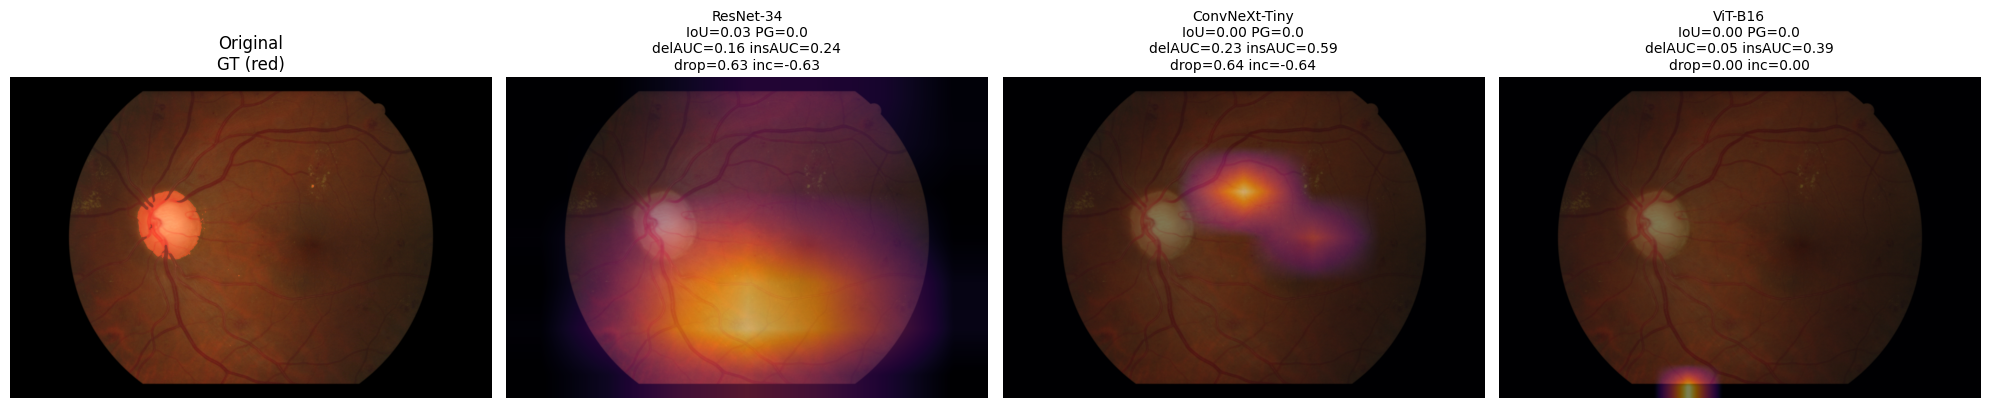

In [94]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original panel
axes[0].imshow(img)
axes[0].imshow(overlay_gt, alpha=0.3)
axes[0].set_title("Original\nGT (red)")
axes[0].axis("off")

# Loop through models
for ax, name in zip(axes[1:], cams):
    mdl, _ = models_map[name]
    cam = cams[name]

    # --- Predict ---
    with torch.no_grad():
        logits = mdl(tensor)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    cls = int(probs.argmax())
    base_conf = float(probs[cls])

    # --- Get CAM map ---
    cam224 = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(cls)])[0]
    camHW = cv2.resize(cam224, (W, H))
    camHW = np.clip(camHW, 0, 1)
    flat = camHW.copy()

    # --- IoU ---
    thr = threshold_otsu(camHW)
    pred = camHW > thr
    iou = compute_iou(pred, gt)

    # --- Pointing Game ---
    peak = np.unravel_index(np.argmax(camHW), camHW.shape)
    pg = float(gt[peak])

    # --- Deletion / Insertion ---
    del_auc = deletion_auc(mdl, base_conf, img, flat, tensor, cls)
    ins_auc = insertion_auc(mdl, base_conf, img, flat, tensor, cls)

    # --- Drop/Increase ---
    p10 = np.percentile(flat, 90)
    top10 = flat >= p10

    m_small = cv2.resize(top10.astype(np.uint8), (W, H),
                         interpolation=cv2.INTER_NEAREST).astype(bool)

    sel = img.copy()
    sel[~m_small] = 0

    x2 = (cv2.resize(sel, (224, 224)).astype(np.float32) / 255.0 - mean) / std
    t2 = torch.from_numpy(x2.transpose(2, 0, 1)).unsqueeze(0).to(device)

    with torch.no_grad():
        c2 = float(F.softmax(mdl(t2), 1)[0, cls])

    drop = base_conf - c2
    inc = c2 - base_conf

    # --- Visualization ---
    heat = (camHW * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_INFERNO)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    blend = ((img * 0.5) + (heat * 0.5)).astype(np.uint8)

    ax.imshow(blend)
    ax.set_title(
        f"{name}\n"
        f"IoU={iou:.2f} PG={pg:.1f}\n"
        f"delAUC={del_auc:.2f} insAUC={ins_auc:.2f}\n"
        f"drop={drop:.2f} inc={inc:.2f}",
        fontsize=10
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

### SHAP Explainability for Three Backbones (ResNet34, ConvNeXt-Tiny, ViT-B/16)

Runs SHAP gradient-based explanations for three deep models using a unified pipeline, computes completeness, deletion/insertion AUC, and infidelity scores, and visualizes SHAP heatmaps alongside saving quantitative metrics.

In [ ]:
import sys
# 0) Force SHAP into PyTorch-only mode
sys.modules['tensorflow'] = None
sys.modules['keras'] = None

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import timm
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import shap
from shap.explainers._gradient import _PyTorchGradient as GradientExplainer
from sklearn.metrics import auc
import pandas as pd

### Fine-tuning wrapper for pretrained backbones  
Defines a model that extracts backbone features and learns a lightweight classifier on top.

In [ ]:
class FineTune(nn.Module):
    def __init__(self, backbone, num_classes=5):
        super().__init__()
        self.backbone = backbone.eval().float()

        # Infer feature dimension
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224).float()
            feats = self.backbone(dummy)
            if feats.ndim == 4:
                feats = F.adaptive_avg_pool2d(feats, (1, 1)).view(1, -1)
            dim = feats.shape[1]

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(dim),
            nn.Dropout(0.3),
            nn.Linear(dim, num_classes)
        ).float()

    def forward(self, x):
        x = x.float()
        feats = self.backbone(x)
        if feats.ndim == 4:
            feats = F.adaptive_avg_pool2d(feats, (1, 1)).view(x.size(0), -1)
        return self.classifier(feats)

### Preprocess

In [ ]:
def preprocess(path, device):
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img = Image.open(path).convert("RGB")
    x = tf(img).unsqueeze(0).to(device).float()

    inv_mean = np.array([0.485, 0.456, 0.406])
    inv_std = np.array([0.229, 0.224, 0.225])

    img_np = x[0].permute(1, 2, 0).cpu().numpy()
    img_disp = np.clip(img_np * inv_std + inv_mean, 0, 1)

    return x, img_disp

### Explainability Metrics

In [ ]:
def _to2d(heat):
    return heat.mean(axis=0) if heat.ndim == 3 else heat

def completeness_error(f, x, heat, baseline):
    px = float(f(x).item())
    pb = float(f(baseline.unsqueeze(0)).item())
    return abs((px - pb) - float(_to2d(heat).sum()))

def deletion_curve_auc(f, x, heat, baseline, steps=50):
    x0 = x[0].clone().detach()
    C, H, W = x0.shape
    flat = np.abs(_to2d(heat)).ravel()
    inds = flat.argsort()[::-1]

    total = H * W
    xs, ys = [], []

    base_flat = baseline.mean(0).view(-1)

    for k in np.linspace(0, total, steps, dtype=int):
        m2 = np.ones(total, bool)
        m2[inds[:k]] = False
        m_full = np.repeat(m2, C)

        xf = x0.view(-1).clone()
        xf[~torch.from_numpy(m_full)] = base_flat[~torch.from_numpy(m_full)]

        ys.append(float(f(xf.view_as(x0).unsqueeze(0)).item()))
        xs.append(k / total)

    return auc(xs, ys)

def insertion_curve_auc(f, x, heat, steps=50):
    x0 = x[0].clone().detach()
    C, H, W = x0.shape

    flat = np.abs(_to2d(heat)).ravel()
    inds = flat.argsort()[::-1]

    total = H * W
    xs, ys = [], []

    zero = torch.zeros_like(x0).view(-1)
    orig = x0.view(-1)

    for k in np.linspace(0, total, steps, dtype=int):
        m2 = np.zeros(total, bool)
        m2[inds[:k]] = True
        m_full = np.repeat(m2, C)

        xin = zero.clone()
        xin[torch.from_numpy(m_full)] = orig[torch.from_numpy(m_full)]

        ys.append(float(f(xin.view_as(x0).unsqueeze(0)).item()))
        xs.append(k / total)

    return auc(xs, ys)

def infidelity(f, x, heat, baseline):
    x0 = x[0]
    z = (baseline.mean(0) - x0).view(-1).cpu().numpy()

    flat = _to2d(heat).ravel()
    C = z.size // flat.size
    phi = np.repeat(flat, C)

    px = float(f(x).item())
    pb = float(f(baseline.mean(0, keepdim=True)).item())

    return ((px - pb) - (phi * z).sum()) ** 2

### Logit Wrapper

In [ ]:
class LogitWrapper(nn.Module):
    def __init__(self, model, class_idx):
        super().__init__()
        self.model = model
        self.class_idx = class_idx

    def forward(self, x):
        logits = self.model(x)
        return logits[:, self.class_idx].unsqueeze(1)
def _make_convnext_backbone():
    m = timm.create_model("convnext_tiny", pretrained=False)
    m.head.fc = nn.Identity()   # keep pooling, remove classifier only
    return m

### Main Execution

/tmp/ipykernel_705973/1351786263.py:275: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.06, 1, 1])


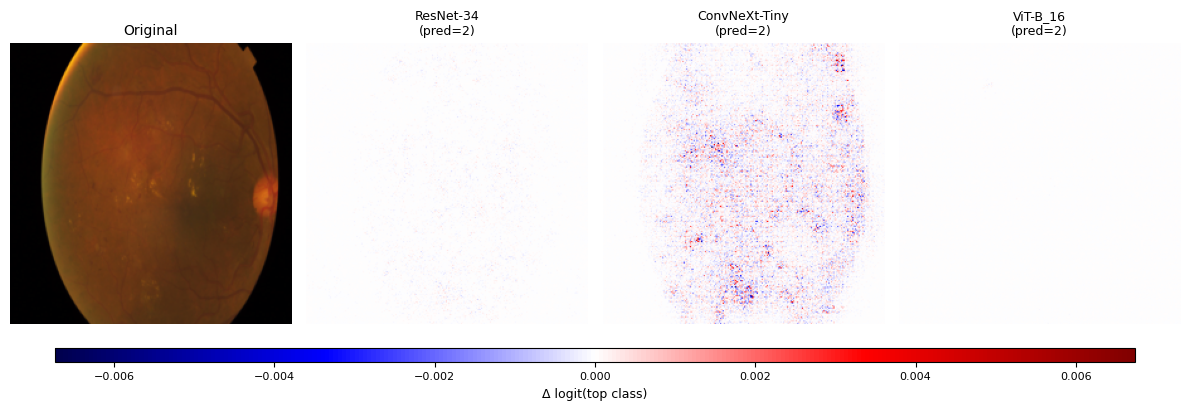

        Model  Pred  Completeness  Deletion AUC  Insertion AUC   Infidelity
    ResNet-34     2      0.019708      4.822235      -0.512592 3.918177e-04
ConvNeXt-Tiny     2      0.025453      4.924926      -2.369132 6.534981e-04
     ViT-B_16     2      0.000143      2.552448      -0.641992 2.075289e-08


In [95]:
if __name__ == "__main__":

    device = torch.device("cpu")

    img_path = "Dataset/val_images/000c1434d8d7.png"
    x, img_disp = preprocess(img_path, device)

    specs = [
        ("ResNet-34",
         lambda: models.resnet34(weights=None),
         "fc",
         "new_saved_models/best_resnet.pth"),

        ("ConvNeXt-Tiny",
         lambda: _make_convnext_backbone(),
         "fc",
         "new_saved_models/best_convnext.pth"),


        ("ViT-B_16",
         lambda: timm.create_model("vit_base_patch16_224", pretrained=False),
         "head",
         "new_saved_models/best_vit.pth"),
    ]

    results = []
    shapmaps = {}

    for name, make_backbone, head_attr, ckpt_file in specs:

        backbone = make_backbone()
        setattr(backbone, head_attr, nn.Identity())

        model = FineTune(backbone).to(device)

        ckpt = torch.load(ckpt_file, map_location=device)
        model.load_state_dict(ckpt["model"])
        model.eval()

        with torch.no_grad():
            pred = int(model(x).argmax())

        wrapped = LogitWrapper(model, pred).to(device)

        baseline = torch.cat([
            x + torch.randn_like(x) * 0.005
            for _ in range(10)
        ], dim=0)

        expl = GradientExplainer(wrapped, baseline, local_smoothing=0.0)
        vals, _ = expl.shap_values(x, nsamples=2000, ranked_outputs=1)

        shap_arr = vals[0] if isinstance(vals, list) else vals
        sv = shap_arr[0]
        heat = sv.mean(axis=0)

        # exact completeness scaling
        with torch.no_grad():
            f_x = float(wrapped(x).item())
            f_b = float(wrapped(baseline.mean(0, keepdim=True)).item())

        delta = f_x - f_b
        s = float(heat.sum())

        if abs(s) > 1e-8:
            heat *= (delta / s)

        ce = completeness_error(wrapped, x, heat, baseline.mean(0))
        delA = deletion_curve_auc(wrapped, x, heat, baseline)
        insA = insertion_curve_auc(wrapped, x, heat)
        inf = infidelity(wrapped, x, heat, baseline)

        results.append({
            "Model": name,
            "Pred": pred,
            "Completeness": ce,
            "Deletion AUC": delA,
            "Insertion AUC": insA,
            "Infidelity": inf
        })

        shapmaps[name] = (heat, pred)


    fig, axes = plt.subplots(1, 4, figsize=(12, 3.5), facecolor='white')

    axes[0].imshow(img_disp)
    axes[0].set_title("Original", fontsize=10)
    axes[0].axis('off')

    all_heats = [shapmaps[n][0] for n, _, _, _ in specs]
    vmax = max(np.abs(h).max() for h in all_heats)

    for i, (name, _, _, _) in enumerate(specs, start=1):
        heat, pred = shapmaps[name]
        ax = axes[i]
        ax.imshow(img_disp)
        im = ax.imshow(heat, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=1.0)
        ax.set_title(f"{name}\n(pred={pred})", fontsize=9)
        ax.axis('off')

    cax = fig.add_axes([0.05, 0.02, 0.9, 0.04])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label("Δ logit(top class)", fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    plt.tight_layout(rect=[0, 0.06, 1, 1])
    plt.savefig("shap_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    df = pd.DataFrame(results)[[
        "Model",
        "Pred",
        "Completeness",
        "Deletion AUC",
        "Insertion AUC",
        "Infidelity"
    ]]

    print(df.to_string(index=False))
    df.to_csv("shap_metrics_comparison.csv", index=False)

### LIME

In [97]:
import sys
# Force LIME into PyTorch-only mode
sys.modules['tensorflow'] = None
sys.modules['keras'] = None

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import timm
from torchvision import transforms
from torchvision.transforms.functional import normalize
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic
from sklearn.metrics import auc
import pandas as pd

### FineTune wrapper (same as SHAP)

In [99]:
class FineTune(nn.Module):
    def __init__(self, backbone, num_classes=5):
        super().__init__()
        self.backbone = backbone.eval().float()

        with torch.no_grad():
            d = torch.randn(1, 3, 224, 224)
            f = self.backbone(d)
            if f.ndim == 4:
                f = F.adaptive_avg_pool2d(f, (1, 1)).view(1, -1)
            dim = f.shape[1]

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(dim),
            nn.Dropout(0.3),
            nn.Linear(dim, num_classes)
        ).float()

    def forward(self, x):
        f = self.backbone(x.float())
        if f.ndim == 4:
            f = F.adaptive_avg_pool2d(f, (1, 1)).view(x.size(0), -1)
        return self.classifier(f)

### Preprocess + display

In [100]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def preprocess(path, device):
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(list(MEAN), list(STD))
    ])

    img = Image.open(path).convert("RGB")
    x = tf(img).unsqueeze(0).to(device)

    arr = x[0].cpu().permute(1, 2, 0).numpy()
    img_disp = np.clip(arr * STD + MEAN, 0, 1)
    return x, img_disp

### Metrics

In [101]:
def _to2d(h):
    return h.mean(axis=0) if h.ndim == 3 else h


def completeness_error(f, x, heat, baseline):
    px = float(f(x).item())
    pb = float(f(baseline).item())
    return abs((px - pb) - float(_to2d(heat).sum()))


def deletion_curve_auc(f, x, heat, baseline, steps=50):
    x0 = x[0].detach()
    C, H, W = x0.shape
    flat = np.abs(_to2d(heat)).ravel()
    inds = flat.argsort()[::-1]

    total = H * W
    xs, ys = [], []
    base_flat = baseline.view(-1)

    for k in np.linspace(0, total, steps, dtype=int):
        m = np.ones(total, bool)
        m[inds[:k]] = False
        mask = np.repeat(m, C)

        xf = x0.view(-1).clone()
        xf[~torch.from_numpy(mask)] = base_flat[~torch.from_numpy(mask)]

        ys.append(float(f(xf.view_as(x0).unsqueeze(0)).item()))
        xs.append(k / total)

    return auc(xs, ys)


def insertion_curve_auc(f, x, heat, baseline, steps=50):
    x0 = x[0].detach()
    C, H, W = x0.shape
    flat = np.abs(_to2d(heat)).ravel()
    inds = flat.argsort()[::-1]

    total = H * W
    xs, ys = [], []
    zero = torch.zeros_like(x0).view(-1)
    orig = x0.view(-1)

    for k in np.linspace(0, total, steps, dtype=int):
        m = np.zeros(total, bool)
        m[inds[:k]] = True
        mask = np.repeat(m, C)

        xin = zero.clone()
        xin[torch.from_numpy(mask)] = orig[torch.from_numpy(mask)]

        ys.append(float(f(xin.view_as(x0).unsqueeze(0)).item()))
        xs.append(k / total)

    return auc(xs, ys)


def infidelity(f, x, heat, baseline):
    x0 = x[0]
    z = (baseline - x0).view(-1).cpu().numpy()
    flat = _to2d(heat).ravel()
    C = z.size // flat.size
    phi = np.repeat(flat, C)

    px = float(f(x).item())
    pb = float(f(baseline).item())
    return ((px - pb) - (phi * z).sum()) ** 2

### Probability Wrapper for LIME

In [ ]:
class ProbWrapper(nn.Module):
    def __init__(self, model, class_idx, device):
        super().__init__()
        self.model = model
        self.idx = class_idx
        self.dev = device

    def forward(self, batch_np):
        proc = []
        for img in batch_np:
            t = torch.from_numpy(img.transpose(2, 0, 1)).float()
            t = normalize(t, torch.tensor(MEAN), torch.tensor(STD))
            proc.append(t)

        xb = torch.stack(proc, 0).to(self.dev)

        with torch.no_grad():
            logits = self.model(xb)
            probs = torch.softmax(logits, dim=1)[:, self.idx]

        return probs.cpu().numpy().reshape(-1, 1)

In [102]:
def make_convnext_backbone():
    m = timm.create_model("convnext_tiny", pretrained=False)
    m.head.fc = nn.Identity()     # keep global_pool, norm, flatten
    return m

### MAIN LOOP

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_705973/3719721324.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.06, 1, 1])


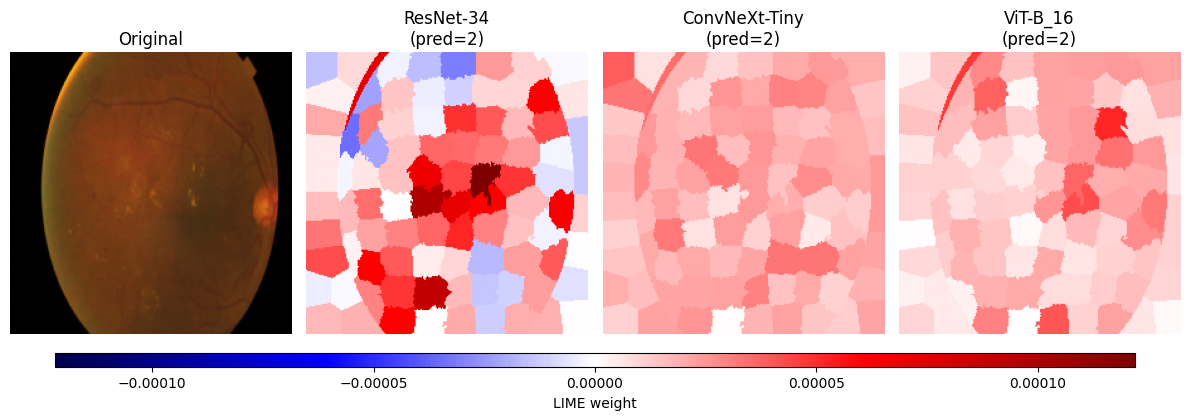

        Model  Pred  Completeness  Deletion AUC  Insertion AUC  Infidelity
    ResNet-34     2      0.978360      0.000757       0.012007         0.0
ConvNeXt-Tiny     2      0.978252      0.002077       0.001224         0.0
     ViT-B_16     2      0.775727      0.003818       0.002979         0.0


In [103]:
if __name__ == "__main__":

    device = torch.device("cpu")

    img_path = "Dataset/val_images/000c1434d8d7.png"
    x, img_disp = preprocess(img_path, device)

    specs = [
        ("ResNet-34",
         lambda: models.resnet34(weights=None),
         "fc",
         "new_saved_models/best_resnet.pth"),

        ("ConvNeXt-Tiny",
         lambda: make_convnext_backbone(),
         None,         
         "new_saved_models/best_convnext.pth"),

        ("ViT-B_16",
         lambda: timm.create_model("vit_base_patch16_224", pretrained=False),
         "head",
         "new_saved_models/best_vit.pth")
    ]

    lime_explainer = lime_image.LimeImageExplainer()
    results = []
    heatmaps = {}

    for name, make_bk, head_attr, ckpt_file in specs:

        backbone = make_bk()

        # strip classifier only if needed
        if head_attr is not None:
            setattr(backbone, head_attr, nn.Identity())

        model = FineTune(backbone).to(device)
        ckpt = torch.load(ckpt_file, map_location=device)
        model.load_state_dict(ckpt["model"])
        model.eval()

        with torch.no_grad():
            pred = int(model(x).argmax())

        prob_model = ProbWrapper(model, pred, device)

        def batch_predict(imgs):
            return prob_model(imgs)

        explanation = lime_explainer.explain_instance(
            img_disp,
            classifier_fn=batch_predict,
            top_labels=1,
            hide_color=0,
            num_samples=1000,
            segmentation_fn=lambda im: slic(im, n_segments=100, compactness=10)
        )

        segs = explanation.segments
        lab = explanation.top_labels[0]
        local = dict(explanation.local_exp[lab])

        heat = np.zeros_like(segs, float)
        for seg_id, weight in local.items():
            heat[segs == seg_id] = weight

        mean_img = x.mean(0, keepdim=True)
        mean_img_np = mean_img.cpu().permute(0, 2, 3, 1).numpy()

        p_x = prob_model(img_disp[np.newaxis, ...])[0, 0]
        p_b = prob_model(mean_img_np)[0, 0]
        delta = p_x - p_b
        s = heat.sum()
        if abs(s) > 1e-8:
            heat *= (delta / s)

        baseline = mean_img.to(device)

        def f_logits(t):
            t_np = t.cpu().permute(0, 2, 3, 1).numpy()
            val = prob_model(t_np)[0]
            return torch.tensor(val)

        ce = completeness_error(f_logits, x, heat, baseline)
        delA = deletion_curve_auc(f_logits, x, heat, baseline)
        insA = insertion_curve_auc(f_logits, x, heat, baseline)
        inf = infidelity(f_logits, x, heat, baseline)

        results.append({
            "Model": name,
            "Pred": pred,
            "Completeness": ce,
            "Deletion AUC": delA,
            "Insertion AUC": insA,
            "Infidelity": inf
        })

        heatmaps[name] = (heat, pred)

    fig, axes = plt.subplots(1, 4, figsize=(12, 3.5), facecolor='white')

    axes[0].imshow(img_disp)
    axes[0].set_title("Original")
    axes[0].axis("off")

    vmax = max(abs(h).max() for h, _ in heatmaps.values())

    for i, (name, _, _, _) in enumerate(specs, start=1):
        heat, pred = heatmaps[name]
        ax = axes[i]
        ax.imshow(img_disp)
        ax.imshow(heat, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=1)
        ax.set_title(f"{name}\n(pred={pred})")
        ax.axis("off")

    cax = fig.add_axes([0.05, 0.02, 0.9, 0.04])
    mappable = axes[-1].images[-1]
    fig.colorbar(mappable, cax=cax, orientation='horizontal', label="LIME weight")

    plt.tight_layout(rect=[0, 0.06, 1, 1])
    plt.show()

    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    df.to_csv("lime_metrics_comparison.csv", index=False)

In [ ]:
import sys
# Force LIME into PyTorch-only mode
sys.modules['tensorflow'] = None
sys.modules['keras'] = None

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import timm
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic
from sklearn.metrics import auc
import pandas as pd

In [ ]:
class FineTune(nn.Module):
    def __init__(self, backbone, num_classes=5):
        super().__init__()
        self.backbone = backbone.eval().float()

        # infer feature dim
        with torch.no_grad():
            d = torch.randn(1, 3, 224, 224)
            f = self.backbone(d)
            if f.ndim == 4:
                f = F.adaptive_avg_pool2d(f, (1, 1)).view(1, -1)
            dim = f.shape[1]

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(dim),
            nn.Dropout(0.3),
            nn.Linear(dim, num_classes)
        ).float()

    def forward(self, x):
        f = self.backbone(x.float())
        if f.ndim == 4:
            f = F.adaptive_avg_pool2d(f, (1, 1)).view(x.size(0), -1)
        return self.classifier(f)

MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])

def preprocess(path, device):
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN.tolist(), STD.tolist())
    ])
    img = Image.open(path).convert("RGB")
    x = tf(img).unsqueeze(0).to(device)
    return x

def load_raw_rgb(path):
    """Load original RGB 0–1 for passing to LIME."""
    img = cv2.imread(path)[:, :, ::-1] / 255.0
    return img.astype(np.float32)

def _to2d(h):
    return h.mean(axis=0) if h.ndim == 3 else h

def completeness_error(f, x, heat, baseline):
    return abs((f(x)[0].item() - f(baseline)[0].item()) - float(_to2d(heat).sum()))

def deletion_curve_auc(f, x, heat, baseline, steps=50):
    x0 = x[0].clone().detach()
    C, H, W = x0.shape
    flat = np.abs(_to2d(heat)).ravel()
    inds = flat.argsort()[::-1]

    total = H * W
    xs, ys = [], []
    base_flat = baseline[0].view(-1)

    for k in np.linspace(0, total, steps, dtype=int):
        m = np.ones(total, bool)
        m[inds[:k]] = False
        mask = np.repeat(m, C)

        xf = x0.view(-1).clone()
        xf[~torch.from_numpy(mask)] = base_flat[~torch.from_numpy(mask)]
        ys.append(float(f(xf.view_as(x0).unsqueeze(0))[0].item()))
        xs.append(k / total)

    return auc(xs, ys)

def insertion_curve_auc(f, x, heat, baseline, steps=50):
    x0 = x[0].clone().detach()
    C, H, W = x0.shape
    flat = np.abs(_to2d(heat)).ravel()
    inds = flat.argsort()[::-1]

    total = H * W
    xs, ys = [], []

    zero = torch.zeros_like(x0).view(-1)
    orig = x0.view(-1)

    for k in np.linspace(0, total, steps, dtype=int):
        m = np.zeros(total, bool)
        m[inds[:k]] = True
        mask = np.repeat(m, C)

        xin = zero.clone()
        xin[torch.from_numpy(mask)] = orig[torch.from_numpy(mask)]
        ys.append(float(f(xin.view_as(x0).unsqueeze(0))[0].item()))
        xs.append(k / total)

    return auc(xs, ys)

def infidelity(f, x, heat, baseline):
    x0 = x[0]
    z = (baseline[0] - x0).view(-1).cpu().numpy()
    flat = _to2d(heat).ravel()
    C = z.size // flat.size
    phi = np.repeat(flat, C)
    return ((f(x)[0].item() - f(baseline)[0].item()) - (phi * z).sum()) ** 2

class ProbWrapper:
    def __init__(self, model, idx, device):
        self.model = model
        self.idx = idx
        self.dev = device

    def __call__(self, batch_np):
        proc = []
        for img in batch_np:
            t = torch.tensor(img.transpose(2, 0, 1)).float()
            t = (t - torch.tensor(MEAN).view(3,1,1)) / torch.tensor(STD).view(3,1,1)
            proc.append(t)

        xb = torch.stack(proc, 0).to(self.dev)
        with torch.no_grad():
            logits = self.model(xb)
            probs = torch.softmax(logits, dim=1)[:, self.idx]

        return probs.cpu().numpy().reshape(-1, 1)

def make_convnext_backbone():
    m = timm.create_model("convnext_tiny", pretrained=False)
    m.head.fc = nn.Identity()   # keep global pool + norm layers
    return m

if __name__ == "__main__":

    device = torch.device("cpu")

    img_path = "Dataset/val_images/000c1434d8d7.png"

    x = preprocess(img_path, device)
    raw_rgb = load_raw_rgb(img_path)   # correct input for LIME

    specs = [
        ("ResNet-34",
         lambda: models.resnet34(weights=None),
         "fc",
         "new_saved_models/best_resnet.pth"),

        ("ConvNeXt-Tiny",
         lambda: make_convnext_backbone(),
         None,
         "new_saved_models/best_convnext.pth"),

        ("ViT-B_16",
         lambda: timm.create_model("vit_base_patch16_224", pretrained=False),
         "head",
         "new_saved_models/best_vit.pth")
    ]

    explainer = lime_image.LimeImageExplainer()
    results = []
    heatmaps = {}

    for name, make_bk, head_attr, ckpt in specs:

        backbone = make_bk()
        if head_attr is not None:
            setattr(backbone, head_attr, nn.Identity())

        model = FineTune(backbone).to(device)
        model.load_state_dict(torch.load(ckpt, map_location=device)["model"])
        model.eval()

        # model prediction
        with torch.no_grad():
            pred = int(model(x).argmax())

        pw = ProbWrapper(model, pred, device)

        # hide color = black (paper uses this)
        hide_color = 0

        # run LIME with SLIC (correct superpixels)
        exp = explainer.explain_instance(
            raw_rgb,
            classifier_fn=pw,
            top_labels=1,
            hide_color=hide_color,
            num_samples=2000,
            segmentation_fn=lambda img: slic(img, n_segments=120, compactness=10, sigma=1)
        )

        segs = exp.segments
        label = exp.top_labels[0]
        local = dict(exp.local_exp[label])

        # build heatmap
        heat = np.zeros_like(segs, float)
        for sid, w in local.items():
            heat[segs == sid] = w

        # completeness scaling
        mean_img = x.mean(0, keepdim=True)
        p_x = pw(raw_rgb[np.newaxis, ...])[0, 0]
        p_b = pw(mean_img.cpu().permute(0,2,3,1).numpy())[0, 0]

        delta = p_x - p_b
        s = heat.sum()
        if abs(s) > 1e-8:
            heat *= (delta / s)

        baseline = mean_img

        # metric-wrapper (returns logits as required)
        def f_logits(t):
            np_inp = t.detach().cpu().permute(0,2,3,1).numpy()
            out = pw(np_inp)
            return torch.tensor(out).to(device)

        ce   = completeness_error(f_logits, x, heat, baseline)
        delA = deletion_curve_auc(f_logits, x, heat, baseline)
        insA = insertion_curve_auc(f_logits, x, heat, baseline)
        inf  = infidelity(f_logits, x, heat, baseline)

        results.append({
            "Model": name,
            "Pred": pred,
            "Completeness": ce,
            "Deletion AUC": delA,
            "Insertion AUC": insA,
            "Infidelity": inf
        })

        heatmaps[name] = (heat, pred)

    fig, axes = plt.subplots(1, 4, figsize=(12, 3.5))

    axes[0].imshow(raw_rgb)
    axes[0].set_title("Original")
    axes[0].axis("off")

    vmax = max(abs(h).max() for h,_ in heatmaps.values())

    for i, (name, _, _, _) in enumerate(specs, start=1):
        heat, pred = heatmaps[name]
        ax = axes[i]
        ax.imshow(raw_rgb)
        ax.imshow(heat, cmap="seismic", vmin=-vmax, vmax=vmax, alpha=1)
        ax.set_title(f"{name}\n(pred={pred})")
        ax.axis("off")

    # Colorbar
    cax = fig.add_axes([0.05, 0.02, 0.9, 0.04])
    mappable = axes[-1].images[-1]
    fig.colorbar(mappable, cax=cax, orientation="horizontal", label="LIME weight")

    plt.tight_layout(rect=[0, 0.06, 1, 1])
    plt.show()

    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    df.to_csv("lime_metrics_comparison.csv", index=False)

### Imports

In [104]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt

from torchvision import models
from torchvision.models import ResNet34_Weights
from captum.attr import GradientShap
from skimage.filters import threshold_otsu
from sklearn.metrics import auc

### XAI Metrics

In [114]:
def compute_iou(pred, gt):
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return inter / (union + 1e-8)


def concentration_ratio(attr, gt):
    total = attr.sum() + 1e-8
    inside = attr[gt].sum()
    return inside / total


def deletion_insertion(model, baseline, inp, target, attr_224, steps=50):
    H224, W224 = attr_224.shape
    pix_n = H224 * W224

    idxs_pix = np.argsort(-attr_224.flatten())
    idxs_flat = np.concatenate([
        idxs_pix,
        idxs_pix + pix_n,
        idxs_pix + 2 * pix_n
    ])

    del_conf = [F.softmax(model(inp), 1)[0, target].item()]
    ins_conf = [F.softmax(model(baseline), 1)[0, target].item()]

    inp_flat = inp.clone().reshape(-1)
    base_flat = baseline.clone().reshape(-1)

    for k in np.linspace(1, pix_n - 1, steps, dtype=int):
        topk = idxs_flat[:3 * k]

        # deletion
        d = inp_flat.clone()
        d[topk] = base_flat[topk]
        cd = d.reshape(inp.shape)
        with torch.no_grad():
            del_conf.append(F.softmax(model(cd), 1)[0, target].item())

        # insertion
        i = base_flat.clone()
        i[topk] = inp_flat[topk]
        ci = i.reshape(inp.shape)
        with torch.no_grad():
            ins_conf.append(F.softmax(model(ci), 1)[0, target].item())

    x = np.linspace(0, 1, len(del_conf))
    return auc(x, del_conf), auc(x, ins_conf)

### FineTune wrapper

In [115]:
class FineTune(nn.Module):
    def __init__(self, backbone, ckpt_path, num_classes=5):
        super().__init__()
        self.backbone = backbone.eval()

        # Infer feature dimension
        with torch.no_grad():
            d = torch.randn(1, 3, 224, 224)
            f = self.backbone(d)
            if f.ndim == 4:
                f = F.adaptive_avg_pool2d(f, (1, 1)).view(1, -1)
            dim = f.shape[1]

        self.head = nn.Sequential(
            nn.BatchNorm1d(dim),
            nn.Dropout(0.3),
            nn.Linear(dim, num_classes)
        )

        sd = torch.load(ckpt_path, map_location="cpu")["model"]
        self.load_state_dict(sd, strict=False)
        self.eval()

    def forward(self, x):
        f = self.backbone(x)
        if f.ndim == 4:
            f = F.adaptive_avg_pool2d(f, (1, 1)).view(x.size(0), -1)
        return self.head(f)

### Loading Models

In [116]:
device = torch.device("cpu")

# ResNet
r = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
r.fc = nn.Identity()
m_res = FineTune(r, "new_saved_models/best_resnet.pth").to(device)

# ConvNeXt (strip only classifier)
c = timm.create_model("convnext_tiny", pretrained=True)
c.head.fc = nn.Identity()
m_cn = FineTune(c, "new_saved_models/best_convnext.pth").to(device)

# ViT
v = timm.create_model("vit_base_patch16_224", pretrained=True)
v.head = nn.Identity()
m_vit = FineTune(v, "new_saved_models/best_vit.pth").to(device)

models_map = {
    "ResNet-34": m_res,
    "ConvNeXt-Tiny": m_cn,
    "ViT-B16": m_vit
}

### GradientSHAP explainers

In [117]:
gs = {name: GradientShap(model) for name, model in models_map.items()}

orig = cv2.cvtColor(cv2.imread("e-optha/EX/EX17.jpg"), cv2.COLOR_BGR2RGB)
H, W = orig.shape[:2]

gtm = cv2.imread("e-optha/Annotation_EX/EX_GT17.png", cv2.IMREAD_GRAYSCALE)
assert gtm is not None, "GT mask missing"

gt = (gtm > 127)
if gt.shape != (H, W):
    gt = cv2.resize(gt.astype(np.uint8), (W, H), cv2.INTER_NEAREST).astype(bool)

img224 = cv2.resize(orig, (224, 224)).astype(np.float32) / 255.0
mean = np.array([0.485, 0.456, 0.406], np.float32)
std = np.array([0.229, 0.224, 0.225], np.float32)
inp_n = (img224 - mean) / std
tensor = torch.from_numpy(inp_n.transpose(2, 0, 1)).unsqueeze(0).to(device)

baseline = torch.zeros_like(tensor)

### Visualization

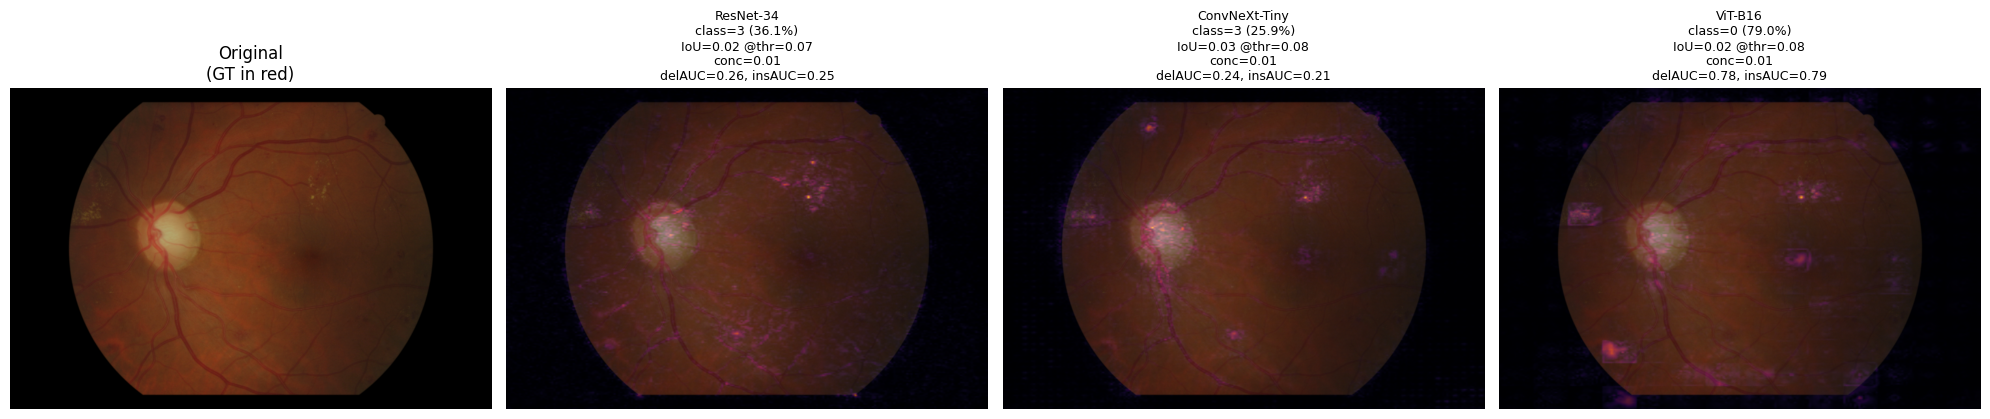

In [118]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(orig)
axes[0].imshow(np.dstack([gt, gt * 0, gt * 0]), alpha=0.3)
axes[0].set_title("Original\n(GT in red)")
axes[0].axis("off")

for ax, (name, model) in zip(axes[1:], models_map.items()):

    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, 1)[0].cpu().numpy()
        cls = int(probs.argmax())
        conf = float(probs.max())

    # Captum GradientSHAP
    attr = gs[name].attribute(
        tensor,
        baselines=baseline,
        stdevs=0.1,
        n_samples=50,
        target=cls
    )[0].cpu().numpy()  # → 3×224×224

    amap224 = np.abs(attr).sum(0)
    amap224 = (amap224 - amap224.min()) / (amap224.max() - amap224.min() + 1e-8)

    amap_hw = cv2.resize(amap224, (W, H), cv2.INTER_LINEAR)

    thr = threshold_otsu(amap_hw)
    pred = amap_hw > thr

    iou = compute_iou(pred, gt)
    conc = concentration_ratio(amap_hw, gt)

    del_auc, ins_auc = deletion_insertion(model, baseline, tensor, cls, amap224)

    # Heatmap
    heat = (255 * amap_hw).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_INFERNO)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    blend = (0.5 * orig + 0.5 * heat).astype(np.uint8)

    ax.imshow(blend)
    ax.set_title(
        f"{name}\n"
        f"class={cls} ({conf*100:.1f}%)\n"
        f"IoU={iou:.2f} @thr={thr:.2f}\n"
        f"conc={conc:.2f}\n"
        f"delAUC={del_auc:.2f}, insAUC={ins_auc:.2f}",
        fontsize=9
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

### Attention Rollouts

In [119]:
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [120]:
MODEL_NAME = "google/vit-base-patch16-224"     # or your fine-tuned repo
CHECKPOINT = "path/to/your/pytorch_model.bin"  # optional local fine-tuned weights
TEST_IMAGE = "Dataset/test_images/e5197d77ec68.png"
OUTPUT_DIR = "xai_vit_attention"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load extractor & model

In [122]:
extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    output_attentions=True,
    ignore_mismatched_sizes=True
)

if os.path.isfile(CHECKPOINT):
    state = torch.load(CHECKPOINT, map_location=DEVICE)
    model.load_state_dict(state, strict=False)

model = model.to(DEVICE).eval()

/home/ubuntu/.local/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Preprocess

In [123]:
def preprocess(path):
    img = Image.open(path).convert("RGB")
    batch = extractor(images=img, return_tensors="pt").pixel_values
    return batch.to(DEVICE)

### Compute Attention Rollout

In [124]:
def attention_rollout(attns):
    """
    attns: tuple of attention maps for each layer
           each of shape (1, heads, N, N)
    """
    # (layers, 1, heads, N, N) → (layers, heads, N, N)
    attn = torch.stack(attns, dim=0)[:, 0]

    # average heads → (layers, N, N)
    attn = attn.mean(dim=1)

    N = attn.size(-1)
    I = torch.eye(N, device=attn.device)

    # Add identity (residual)
    attn = attn + I

    # Normalize rows
    attn = attn / attn.sum(dim=-1, keepdim=True)

    # Rollout (recursive multiplication)
    rollout = attn[0]
    for layer in attn[1:]:
        rollout = layer @ rollout

    # Extract CLS → patch attention (skip CLS token itself)
    cls_to_patches = rollout[0, 1:]

    # Convert to square spatial grid
    side = int(cls_to_patches.numel() ** 0.5)
    mask = cls_to_patches.reshape(side, side).detach().cpu().numpy()

    return mask

### Visualization and Threshold

In [125]:
def visualize(orig_path, mask, threshold_pct=90, heatmap_alpha=0.6,
              colormap=cv2.COLORMAP_JET):

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    orig = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
    h, w = orig.shape[:2]

    # Resize mask to full image
    m = cv2.resize(mask, (w, h))

    # Threshold at percentile
    thr = np.percentile(m, threshold_pct)
    m_thr = np.clip(m - thr, 0, None)
    if m_thr.max() > 0:
        m_thr = m_thr / m_thr.max()

    # Convert to heatmap
    heat = np.uint8(255 * m_thr)
    heat_col = cv2.applyColorMap(heat, colormap)
    overlay = cv2.addWeighted(orig, 1 - heatmap_alpha, heat_col, heatmap_alpha, 0)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.imshow(orig)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(overlay)
    ax2.set_title("ViT Attention Rollout")
    ax2.axis("off")

    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR, "vit_attention_thresh.png")
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print("Saved attention visualization to:", out_path)
    plt.show()

Saved attention visualization to: xai_vit_attention/vit_attention_thresh.png


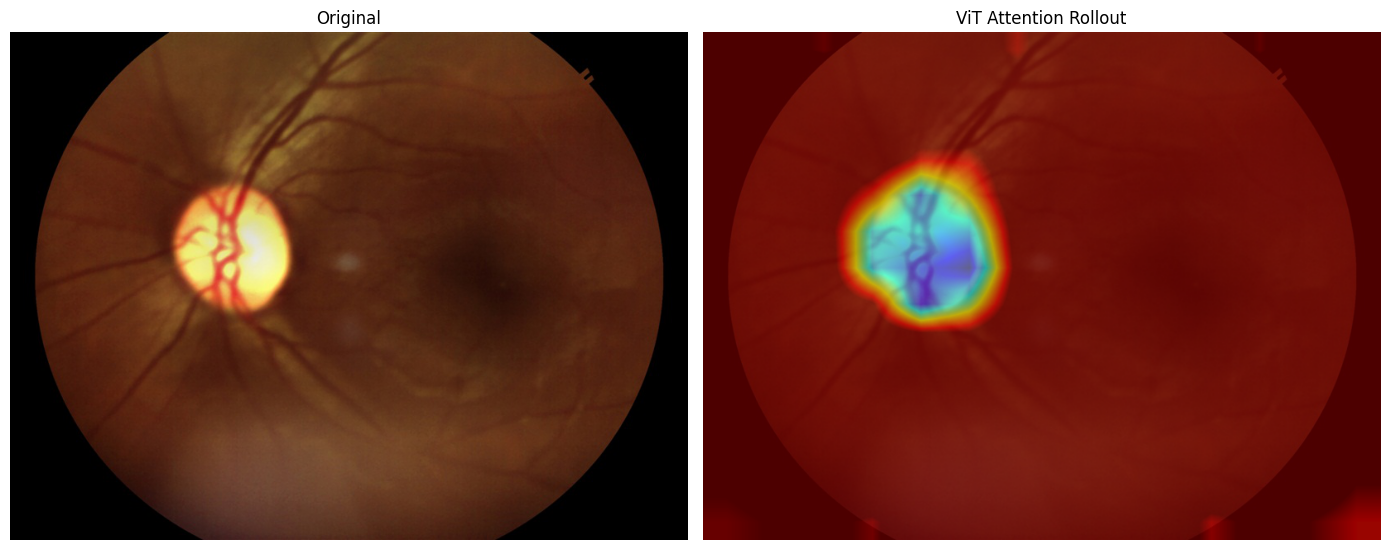

In [126]:
if __name__ == "__main__":
    pixels = preprocess(TEST_IMAGE)

    with torch.no_grad():
        output = model(pixels)
        mask = attention_rollout(output.attentions)

    visualize(TEST_IMAGE, mask)

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import IntegratedGradients
from torchvision import models
from torchvision.models import ResNet34_Weights, DenseNet121_Weights
import timm
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### BaseModel wrapper (returns logits + features)

In [2]:
class BaseModel(nn.Module):
    """
    Wraps a backbone network to output (logits, features) for XAI.
    """

    def __init__(self, backbone: nn.Module, num_classes: int = 5):
        super().__init__()
        self.backbone = backbone

        dummy = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            feats = backbone(dummy)
            if feats.ndim == 4:
                feats = F.adaptive_avg_pool2d(feats, (1, 1))
                feats = feats.view(1, -1)

        dim = feats.size(1)

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(dim),
            nn.Dropout(0.3),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x: torch.Tensor):
        feats = self.backbone(x)
        if feats.ndim == 4:
            feats = F.adaptive_avg_pool2d(feats, (1, 1)).view(feats.size(0), -1)
        logits = self.classifier(feats)
        return logits, feats

### Model Loaders

In [3]:
def load_resnet(ckpt_path: str, device: torch.device):
    backbone = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    backbone.fc = nn.Identity()
    model = BaseModel(backbone)

    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"], strict=False)

    return model.to(device).eval()


def load_densenet(ckpt_path: str, device: torch.device):
    backbone = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    backbone.classifier = nn.Identity()

    # BaseModel takes backbone.features (DenseNet internal conv layers)
    model = BaseModel(backbone.features)

    # -----------------------------
    # Load checkpoint safely
    # -----------------------------
    ckpt = torch.load(ckpt_path, map_location=device)

    # Case 1: checkpoint contains "model"
    if "model" in ckpt:
        state_dict = ckpt["model"]

    # Case 2: checkpoint contains "state_dict"
    elif "state_dict" in ckpt:
        state_dict = ckpt["state_dict"]

    # Case 3: checkpoint is itself a state_dict
    else:
        state_dict = ckpt

    # -----------------------------
    # Load weights into BaseModel
    # -----------------------------
    model.load_state_dict(state_dict, strict=False)

    return model.to(device).eval()


def load_vit(ckpt_path: str, device: torch.device):
    backbone = timm.create_model("vit_base_patch16_224", pretrained=True)

    if hasattr(backbone, "head"):
        backbone.head = nn.Identity()
    elif hasattr(backbone, "fc"):
        backbone.fc = nn.Identity()

    model = BaseModel(backbone)

    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"], strict=False)

    return model.to(device).eval()

### Preprocessing

In [4]:
def preprocess(img_path: str, device: torch.device):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406], np.float32)
    std = np.array([0.229, 0.224, 0.225], np.float32)

    norm = (img_resized - mean) / std
    tensor = torch.from_numpy(norm.transpose(2, 0, 1)).unsqueeze(0).to(device)

    return img, tensor

### Integrated Gradients

In [5]:
def integrated_gradients(model: nn.Module,
                         input_tensor: torch.Tensor,
                         target: int,
                         baseline: torch.Tensor = None,
                         steps: int = 50) -> np.ndarray:
    """
    Computes Integrated Gradients attribution map.
    """

    def forward_fn(x):
        logits, _ = model(x)
        return logits

    ig = IntegratedGradients(forward_fn)

    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    attr, delta = ig.attribute(
        inputs=input_tensor,
        baselines=baseline,
        target=target,
        n_steps=steps,
        return_convergence_delta=True
    )

    return attr.squeeze(0).cpu().numpy()

### Visualization with Circular Retina Mask

In [6]:
def visualize_ig(attr: np.ndarray,
                 orig_img: np.ndarray,
                 out_path: str,
                 alpha: float = 0.6,
                 cmap: str = "jet"):
    """
    Overlay attribution heatmap on original fundus image.
    Applies a circular retina mask to remove outer black regions.
    """

    heat = np.mean(np.maximum(attr, 0), axis=0)
    heat = (heat - heat.min()) / (heat.max() + 1e-8)

    heat_resized = cv2.resize(heat, (orig_img.shape[1], orig_img.shape[0]))

    H, W = heat_resized.shape
    center = (W // 2, H // 2)
    radius = int(min(center) * 0.95)

    Y, X = np.ogrid[:H, :W]
    mask = ((X - center[0]) ** 2 + (Y - center[1]) ** 2) <= radius ** 2
    heat_resized *= mask.astype(float)

    heat_uint8 = np.uint8(255 * heat_resized)
    color_map = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)

    overlay = np.uint8(alpha * color_map + (1 - alpha) * orig_img)

    combo = np.hstack([orig_img, overlay])
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    cv2.imwrite(out_path, cv2.cvtColor(combo, cv2.COLOR_RGB2BGR))

    print(f"Saved IG visualization (retina focus) to {out_path}")

### Runner

In [7]:
def run_ig_for_model(model_loader,
                     ckpt: str,
                     img_path: str,
                     out_dir: str,
                     device: str):

    dev = torch.device(device)
    model = model_loader(ckpt, dev)

    orig, tensor = preprocess(img_path, dev)

    with torch.no_grad():
        target = model(tensor)[0].argmax(dim=1).item()

    attr = integrated_gradients(model, tensor, target)

    base = os.path.splitext(os.path.basename(img_path))[0]
    name = os.path.splitext(os.path.basename(ckpt))[0]

    out_file = os.path.join(out_dir, f"{base}_{name}_ig.png")

    visualize_ig(attr, orig, out_file)

In [8]:
if __name__ == "__main__":

    IMG = "Dataset/test_images/e4dcca36ceb4.png"
    DEV = "cuda" if torch.cuda.is_available() else "cpu"

    OUT = "xai_ig_outputs"
    os.makedirs(OUT, exist_ok=True)

    run_ig_for_model(load_resnet, "new_saved_models/best_resnet.pth", IMG, OUT, DEV)
    run_ig_for_model(load_densenet, "new_saved_models/best_densenet121_model.pth", IMG, OUT, DEV)
    run_ig_for_model(load_vit, "new_saved_models/best_vit.pth", IMG, OUT, DEV)

Saved IG visualization (retina focus) to xai_ig_outputs/e4dcca36ceb4_best_resnet_ig.png


[W1208 01:56:01.061332938 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:01.063900565 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:01.065670990 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:01.067267109 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:02.068849391 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:02.070597654 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:02.072207628 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:02.073780312 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:02.075333450 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1208 01:56:02.076896236 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.


Saved IG visualization (retina focus) to xai_ig_outputs/e4dcca36ceb4_best_densenet121_model_ig.png
Saved IG visualization (retina focus) to xai_ig_outputs/e4dcca36ceb4_best_vit_ig.png


### TCAV - Testing with Concept Activation Vectors

In [9]:
import os
import shutil
import glob

# Adjust these paths:
ORIG_TRAIN = r"idrid_dataset/A. Segmentation/1. Original Images/a. Training Set"
ORIG_TEST  = r"idrid_dataset/A. Segmentation/1. Original Images/b. Testing Set"

BASE = r"concepts"

dst1 = os.path.join(BASE, "random_1")
os.makedirs(dst1, exist_ok=True)

for img in glob.glob(os.path.join(ORIG_TRAIN, "*.jpg")):
    shutil.copy(img, dst1)

dst2 = os.path.join(BASE, "random_2")
os.makedirs(dst2, exist_ok=True)

for img in glob.glob(os.path.join(ORIG_TEST, "*.jpg")):
    shutil.copy(img, dst2)

print("random_1:", len(os.listdir(dst1)), "images")
print("random_2:", len(os.listdir(dst2)), "images")

random_1: 54 images
random_2: 27 images


In [10]:
import os, shutil, glob

ORIG_TRAIN = r"idrid_dataset/A. Segmentation/1. Original Images/a. Training Set"

TARGET_DIR = r"concepts/target_images"

os.makedirs(TARGET_DIR, exist_ok=True)

for img in glob.glob(os.path.join(ORIG_TRAIN, "*.jpg")):
    shutil.copy(img, TARGET_DIR)

print("target_images now has", len(os.listdir(TARGET_DIR)), "images")

target_images now has 216 images


In [11]:
import os
import shutil
import pandas as pd

BASE_DIR = r"idrid_dataset/B. Disease Grading/"
GT_DIR = os.path.join(BASE_DIR, "2. Groundtruths")
IMG_PARENT = os.path.join(BASE_DIR, "1. Original Images")

TARGET_DIR = os.path.join("concepts", "target_images")
os.makedirs(TARGET_DIR, exist_ok=True)

TRAIN_CSV = os.path.join(GT_DIR, "a. IDRiD_Disease Grading_Training Labels.csv")
TEST_CSV  = os.path.join(GT_DIR, "b. IDRiD_Disease Grading_Testing Labels.csv")

folders = os.listdir(IMG_PARENT)
print("Available subfolders:", folders)

train_folder = next(d for d in folders if "train" in d.lower())
test_folder  = next(d for d in folders if "test" in d.lower())

IMG_TRAIN = os.path.join(IMG_PARENT, train_folder)
IMG_TEST  = os.path.join(IMG_PARENT, test_folder)

print(f"Training images in: {IMG_TRAIN}")
print(f"Testing images in : {IMG_TEST}")

df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)

df_all = pd.concat([df_train, df_test], ignore_index=True)

filename_col = "Image name"
label_col = "Retinopathy grade"

df2 = df_all[df_all[label_col] == 2]
print(f"Found {len(df2)} images labeled '2'")

copied = 0

for fn in df2[filename_col]:

    # Ensure filename ends with .jpg
    if not fn.lower().endswith(".jpg"):
        fn = fn + ".jpg"

    # Try training folder first
    src = os.path.join(IMG_TRAIN, fn)

    # If not found, try test folder
    if not os.path.exists(src):
        src = os.path.join(IMG_TEST, fn)

    # If still not found, report missing file
    if not os.path.exists(src):
        print("⚠ Missing file:", fn)
        continue

    shutil.copy(src, os.path.join(TARGET_DIR, fn))
    copied += 1

print(f"Copied {copied} images to '{TARGET_DIR}'")

Available subfolders: ['a. Training Set', 'b. Testing Set']
Training images in: idrid_dataset/B. Disease Grading/1. Original Images/a. Training Set
Testing images in : idrid_dataset/B. Disease Grading/1. Original Images/b. Testing Set
Found 168 images labeled '2'
Copied 168 images to 'concepts/target_images'


### TCAV Pipeline: Concept Dataset Loading, CAV Training, and Class-Specific TCAV Scoring

Implements a full TCAV workflow using ResNet50 activations, including concept and random dataset loaders, activation extraction with hooks, CAV training via logistic regression, and final TCAV directional-derivative scores for a target class.

In [12]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 5
BOTTLENECK_LAYER = "layer3"
CHECKPOINT_PATH = "new_saved_models/best_resnet.pth"

# Load ResNet50
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

# Load checkpoint robustly
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
if "model" in ckpt:
    state_dict = ckpt["model"]
elif "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
else:
    state_dict = ckpt

if hasattr(state_dict, "state_dict"):
    state_dict = state_dict.state_dict()

model.load_state_dict(state_dict, strict=False)
model = model.to(DEVICE).eval()

acts, grads = [], []

def forward_hook(module, inp, out):
    acts.append(out.detach().cpu().view(out.size(0), -1))

def backward_hook(module, grad_in, grad_out):
    g = grad_out[0].detach().cpu().view(grad_out[0].size(0), -1)
    grads.append(g)

for name, mod in model.named_modules():
    if name.endswith(BOTTLENECK_LAYER):
        mod.register_forward_hook(forward_hook)
        mod.register_full_backward_hook(backward_hook)
        print(f"Hook attached to: {name}")

CONCEPT_DIR = "concepts"
CONCEPTS = [
    "optic_disc",
    "microaneurysms",
    "hard_exudates",
    "soft_exudates",
    "haemorrhages"
]

RANDOMS = ["random_1", "random_2"]
TARGET_FOLDER = "target_images"

BATCH_SIZE = 16
NUM_WORKERS = 0

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

class ImgFolder(Dataset):
    def __init__(self, folder, exts=("png", "jpg", "jpeg", "tif")):
        self.paths = []
        for ext in exts:
            self.paths += glob.glob(os.path.join(folder, f"*.{ext}"))
        self.tf = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        return self.tf(img), path


def make_loader(subfolder):
    folder = os.path.join(CONCEPT_DIR, subfolder)
    ds = ImgFolder(folder)
    print(f"Folder '{subfolder}' contains {len(ds)} images")
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


all_loaders = {
    name: make_loader(name)
    for name in CONCEPTS + RANDOMS + [TARGET_FOLDER]
}

def collect_acts(loader):
    acts.clear()
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            _ = model(xb)
    if len(acts) == 0:
        return None
    return torch.cat(acts, dim=0).numpy()

cavs = {}

for concept in CONCEPTS:
    print(f"\nTraining CAV for concept '{concept}'")

    pos = collect_acts(all_loaders[concept])

    if pos is None:
        print(f"Skipping concept '{concept}' — no positive examples.")
        continue

    neg_list = []
    for r in RANDOMS:
        n = collect_acts(all_loaders[r])
        if n is not None:
            neg_list.append(n)

    if len(neg_list) == 0:
        print(f"Skipping concept '{concept}' — no negative examples.")
        continue

    neg = np.vstack(neg_list)

    X = np.vstack([pos, neg])
    y = np.array([1] * len(pos) + [0] * len(neg))

    lr = LogisticRegression(max_iter=2000).fit(X, y)
    cavs[concept] = lr.coef_.ravel()

    print(f" → CAV dimension = {cavs[concept].shape[0]}")

def tcav_scores(loader, target_class):
    scores = {c: [] for c in cavs.keys()}  # only concepts with CAVs

    for xb, _ in loader:
        xb = xb.to(DEVICE).requires_grad_(True)

        acts.clear()
        grads.clear()

        logits = model(xb)
        loss = logits[:, target_class].sum()

        model.zero_grad()
        loss.backward(retain_graph=True)

        G = grads[-1].numpy()

        for c, cav in cavs.items():
            dd = G.dot(cav)
            scores[c].append((dd > 0).mean())

    return {c: float(np.mean(scores[c])) for c in scores.keys()}

TARGET_CLASS = 2

print(f"\nTCAV Scores for Class {TARGET_CLASS}:\n")
results = tcav_scores(all_loaders[TARGET_FOLDER], TARGET_CLASS)

for c, sc in results.items():
    print(f"{c:20s} : {sc:.4f}")

/home/ubuntu/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Hook attached to: layer3
Folder 'optic_disc' contains 54 images
Folder 'microaneurysms' contains 54 images
Folder 'hard_exudates' contains 54 images
Folder 'soft_exudates' contains 26 images
Folder 'haemorrhages' contains 53 images
Folder 'random_1' contains 54 images
Folder 'random_2' contains 27 images
Folder 'target_images' contains 211 images

Training CAV for concept 'optic_disc'
 → CAV dimension = 200704

Training CAV for concept 'microaneurysms'
 → CAV dimension = 200704

Training CAV for concept 'hard_exudates'
 → CAV dimension = 200704

Training CAV for concept 'soft_exudates'
 → CAV dimension = 200704

Training CAV for concept 'haemorrhages'
 → CAV dimension = 200704

TCAV Scores for Class 2:

optic_disc           : 0.0045
microaneurysms       : 0.0045
hard_exudates        : 0.0045
soft_exudates        : 0.0045
haemorrhages         : 0.0045


### TCAV Score Matrix and Heatmap Visualization

Computes TCAV scores for every class–concept pair and visualizes the results as a heatmap for comparative interpretability.

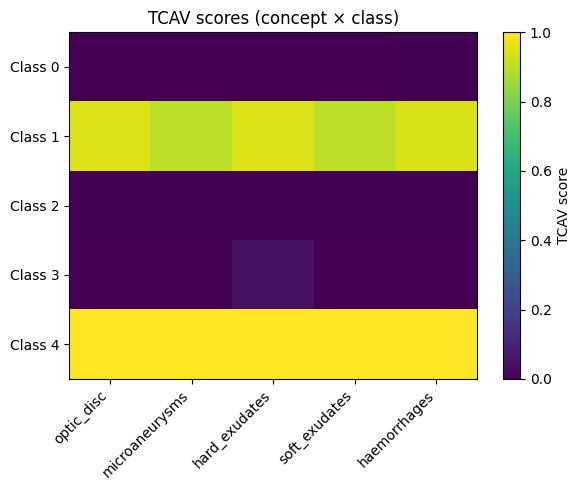

In [13]:
all_scores = np.zeros((NUM_CLASSES, len(CONCEPTS)))

for cls in range(NUM_CLASSES):
    sc = tcav_scores(all_loaders[TARGET_FOLDER], cls)
    for j, concept in enumerate(CONCEPTS):
        all_scores[cls, j] = sc[concept]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(all_scores, vmin=0, vmax=1, aspect='auto')

ax.set_xticks(np.arange(len(CONCEPTS)))
ax.set_yticks(np.arange(NUM_CLASSES))

ax.set_xticklabels(CONCEPTS, rotation=45, ha='right')
ax.set_yticklabels([f"Class {i}" for i in range(NUM_CLASSES)])

ax.set_title("TCAV scores (concept × class)")
plt.colorbar(im, ax=ax, label="TCAV score")
plt.tight_layout()
plt.show()

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 5
BOTTLENECK_LAYER = "layer4"
CHECKPOINT_PATH = "new_saved_models/best_resnet.pth"

model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
if "model" in ckpt:
    state_dict = ckpt["model"]
elif "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
else:
    state_dict = ckpt
if hasattr(state_dict, "state_dict"):
    state_dict = state_dict.state_dict()

model.load_state_dict(state_dict, strict=False)
model = model.to(DEVICE).eval()

In [ ]:
acts, grads = [], []

def forward_hook(module, inp, out):
    acts.append(out.detach().cpu().view(out.size(0), -1))

def backward_hook(module, grad_inp, grad_out):
    grads.append(grad_out[0].detach().cpu().view(grad_out[0].size(0), -1))

for name, mod in model.named_modules():
    if name.endswith(BOTTLENECK_LAYER):
        mod.register_forward_hook(forward_hook)
        mod.register_full_backward_hook(backward_hook)
        print(f"Hook attached to: {name}")

In [ ]:
CONCEPT_DIR = "concepts"
CONCEPTS = [
    "optic_disc", "microaneurysms",
    "hard_exudates", "soft_exudates",
    "haemorrhages"
]

RANDOMS = ["random_1", "random_2"]
TARGET_FOLDER = "target_images"

BATCH_SIZE = 16
NUM_WORKERS = 0

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class ImgFolder(Dataset):
    def __init__(self, folder, exts=("png","jpg","jpeg","tif")):
        self.paths = []
        for ext in exts:
            self.paths += glob.glob(os.path.join(folder, f"*.{ext}"))
        self.tf = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.tf(img), self.paths[idx]


def make_loader(name):
    folder = os.path.join(CONCEPT_DIR, name)
    ds = ImgFolder(folder)
    print(f"Folder '{name}' contains {len(ds)} images")
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


all_loaders = {name: make_loader(name) for name in CONCEPTS + RANDOMS + [TARGET_FOLDER]}

### Activation Collection Helper

Runs a loader through the model to gather bottleneck-layer activations, safely handling empty datasets by returning `None`.

In [ ]:
def collect_acts(loader):
    acts.clear()
    with torch.no_grad():
        for xb, _ in loader:
            model(xb.to(DEVICE))

    if len(acts) == 0:
        return None      # <-- FIX (avoid crash)

    return torch.cat(acts, dim=0).numpy()

### Train CAVs for Each Concept

Builds positive and negative activation sets for every concept, fits a logistic regression classifier, and stores the resulting CAV vectors.

In [ ]:
cavs = {}

for concept in CONCEPTS:
    print(f"\nTraining CAV for concept '{concept}'")

    pos = collect_acts(all_loaders[concept])
    if pos is None:
        print(f"Skipping '{concept}' — NO POSITIVE IMAGES.")
        continue

    neg_sets = []
    for r in RANDOMS:
        neg = collect_acts(all_loaders[r])
        if neg is not None:
            neg_sets.append(neg)

    if len(neg_sets) == 0:
        print(f"Skipping '{concept}' — NO NEGATIVE IMAGES.")
        continue

    neg = np.vstack(neg_sets)

    X = np.vstack([pos, neg])
    y = np.array([1]*len(pos) + [0]*len(neg))

    lr = LogisticRegression(max_iter=2000).fit(X, y)
    cavs[concept] = lr.coef_.ravel()
    print(f" → CAV learned ({len(cavs[concept])} dim)")

### TCAV Scoring Function

Computes directional derivatives for a target class across a dataset and returns concept-wise TCAV scores based on the learned CAV vectors.

In [ ]:
def tcav_scores(loader, target_class):
    if len(cavs) == 0:
        print("No CAVs available; cannot compute TCAV.")
        return {}

    scores = {c: [] for c in cavs.keys()}

    for xb, _ in loader:
        xb = xb.to(DEVICE).requires_grad_(True)

        acts.clear()
        grads.clear()

        logits = model(xb)
        loss = logits[:, target_class].sum()

        model.zero_grad()
        loss.backward()

        G = grads[-1].numpy()

        for c, cav_vec in cavs.items():
            dd = G.dot(cav_vec)
            scores[c].append((dd > 0).mean())

    return {c: float(np.mean(scores[c])) for c in scores.keys()}

### Compute and Display TCAV Scores for the Target Class

Evaluates TCAV scores for the selected class using its target dataset and prints concept-wise results.

In [ ]:
TARGET_CLASS = 2

print(f"\nTCAV Scores for Class {TARGET_CLASS}:")
scores = tcav_scores(all_loaders[TARGET_FOLDER], TARGET_CLASS)

for c, s in scores.items():
    print(f"{c:20s} : {s:.4f}")

In [ ]:
valid_concepts = list(cavs.keys())
heat = np.zeros((NUM_CLASSES, len(valid_concepts)))

for cls in range(NUM_CLASSES):
    sc = tcav_scores(all_loaders[TARGET_FOLDER], cls)
    for j, c in enumerate(valid_concepts):
        heat[cls,j] = sc[c]

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(heat, vmin=0, vmax=1, aspect='auto')

ax.set_xticks(np.arange(len(valid_concepts)))
ax.set_xticklabels(valid_concepts, rotation=45, ha='right')

ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_yticklabels([f"Class {i}" for i in range(NUM_CLASSES)])

ax.set_title("TCAV Scores Heatmap")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

def tcav_raw_dd(loader, target_class):
    raw = {c: [] for c in CONCEPTS}

    for xb, _ in loader:
        xb = xb.to(DEVICE).requires_grad_(True)

        acts.clear()
        grads.clear()

        logits = model(xb)
        loss = logits[:, target_class].sum()
        model.zero_grad()
        loss.backward(retain_graph=True)

        G = grads[-1].numpy()

        for c in CONCEPTS:
            raw[c].extend(G.dot(cavs[c]))

    return {c: np.array(raw[c]) for c in CONCEPTS}

### Bootstrap Confidence Intervals for TCAV Scores

Generates bootstrap samples of directional derivatives to estimate 95% confidence intervals for each concept's TCAV score for the selected class.

/home/ubuntu/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Hook attached to: layer4
Folder 'optic_disc' contains 54 images
Folder 'microaneurysms' contains 54 images
Folder 'hard_exudates' contains 54 images
Folder 'soft_exudates' contains 26 images
Folder 'haemorrhages' contains 53 images
Folder 'random_1' contains 54 images
Folder 'random_2' contains 27 images
Folder 'target_images' contains 211 images

Training CAV for concept 'optic_disc'
 → CAV learned (100352 dim)

Training CAV for concept 'microaneurysms'
 → CAV learned (100352 dim)

Training CAV for concept 'hard_exudates'
 → CAV learned (100352 dim)

Training CAV for concept 'soft_exudates'
 → CAV learned (100352 dim)

Training CAV for concept 'haemorrhages'
 → CAV learned (100352 dim)

TCAV Scores for Class 2:
optic_disc           : 1.0000
microaneurysms       : 1.0000
hard_exudates        : 1.0000
soft_exudates        : 1.0000
haemorrhages         : 1.0000


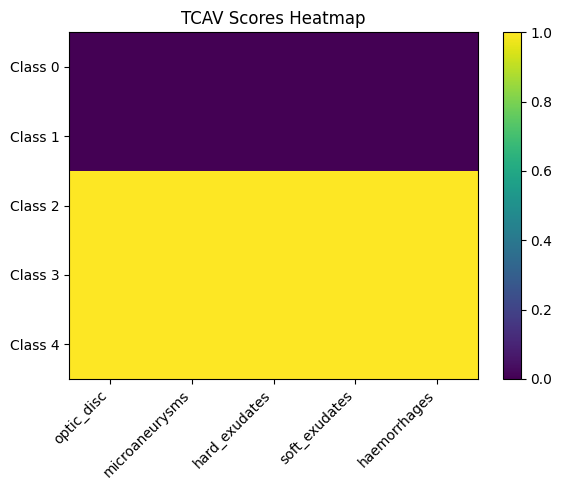


95% CIs for TCAV(Class 2):
 optic_disc     : 1.000 [1.000, 1.000]
 microaneurysms : 1.000 [1.000, 1.000]
 hard_exudates  : 1.000 [1.000, 1.000]
 soft_exudates  : 1.000 [1.000, 1.000]
 haemorrhages   : 1.000 [1.000, 1.000]


In [51]:
# bootstrap for class 2
raw_dd = tcav_raw_dd(all_loaders[TARGET_FOLDER], TARGET_CLASS)

n_boot = 500
ci_lower, ci_upper = {}, {}

for c in CONCEPTS:
    samp = raw_dd[c]
    boot_means = []

    for _ in range(n_boot):
        bs = np.random.choice(samp, size=len(samp), replace=True)
        boot_means.append((bs > 0).mean())

    ci_lower[c], ci_upper[c] = np.percentile(boot_means, [2.5, 97.5])

print(f"\n95% CIs for TCAV(Class {TARGET_CLASS}):")
for c in CONCEPTS:
    mean = (raw_dd[c] > 0).mean()
    print(f" {c:15s}: {mean:.3f} [{ci_lower[c]:.3f}, {ci_upper[c]:.3f}]")

### Statistical Significance Testing and Confidence Intervals for Directional Derivatives

Performs one-sided t-tests (with Bonferroni correction) to assess whether directional derivatives are significantly greater than zero for each concept, and visualizes mean values with 95% confidence intervals.


One-sample t-tests for DD > 0 (class 2):
 optic_disc      mean=+1.50e-05,  t=190264819825438176.00,  p=0.00e+00   significant? YES
 microaneurysms  mean=+1.53e-05,  t=53347517956837360.00,  p=0.00e+00   significant? YES
 hard_exudates   mean=+1.59e-05,  t=42327951599864472.00,  p=0.00e+00   significant? YES
 soft_exudates   mean=+1.78e-05,  t=37393968582830248.00,  p=0.00e+00   significant? YES
 haemorrhages    mean=+1.64e-05,  t=63140186176181160.00,  p=0.00e+00   significant? YES


/home/ubuntu/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


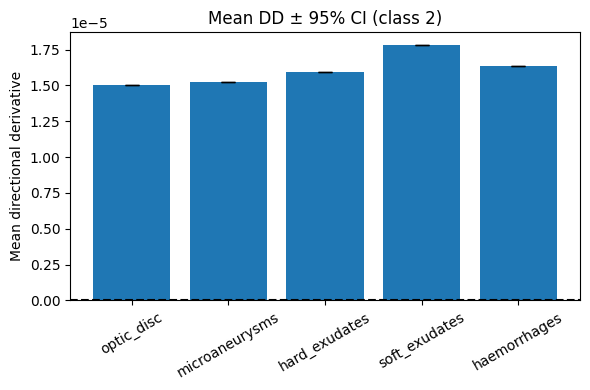

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

valid_concepts = [c for c in CONCEPTS if c in raw_dd and len(raw_dd[c]) > 0]

if len(valid_concepts) == 0:
    print("No concepts contain directional-derivative values. Cannot run t-tests or CI plots.")
else:

    print(f"\nOne-sample t-tests for DD > 0 (class {TARGET_CLASS}):")

    alpha = 0.05 / len(valid_concepts)   # Bonferroni correction

    for c in valid_concepts:
        dd = raw_dd[c]

        # t-test (one-sided, mean > 0)
        t_stat, p_val = ttest_1samp(dd, 0.0, alternative='greater')

        signif = "YES" if p_val < alpha else "no"

        print(f" {c:15s} mean={dd.mean():+.2e},  t={t_stat:.2f},  p={p_val:.2e}   significant? {signif}")

    means = []
    cis = []

    for c in valid_concepts:
        dd = raw_dd[c]
        m = dd.mean()
        sem = dd.std(ddof=1) / np.sqrt(len(dd))
        ci = 1.96 * sem  # 95% CI

        means.append(m)
        cis.append(ci)

    plt.figure(figsize=(6,4))
    plt.bar(valid_concepts, means, yerr=cis, capsize=5)
    plt.axhline(0, color='k', linestyle='--')
    plt.ylabel("Mean directional derivative")
    plt.xticks(rotation=30)
    plt.title(f"Mean DD ± 95% CI (class {TARGET_CLASS})")
    plt.tight_layout()
    plt.show()

### Wilcoxon Signed-Rank Test for Directional Derivatives

Applies a one-sided Wilcoxon signed-rank test to evaluate whether each concept's directional derivatives are significantly greater than zero, handling empty and zero-only cases gracefully.

In [53]:
from scipy.stats import wilcoxon

print(f"\nWilcoxon signed-rank (greater) for class {TARGET_CLASS}:")

for c in CONCEPTS:

    # Check concept exists and non-empty
    if c not in raw_dd or len(raw_dd[c]) == 0:
        print(f" {c:15s}: no data available")
        continue

    dd = raw_dd[c]

    # remove exact zeros (Wilcoxon cannot handle ties-at-zero)
    dd_nz = dd[dd != 0]

    if len(dd_nz) < 1:
        print(f" {c:15s}: no nonzero samples")
        continue

    # Wilcoxon signed-rank test (one-sided: mean(dd) > 0)
    stat, p = wilcoxon(dd_nz, alternative="greater")

    print(f" {c:15s} p={p:.2e}")


Wilcoxon signed-rank (greater) for class 2:
 optic_disc      p=1.77e-47
 microaneurysms  p=1.77e-47
 hard_exudates   p=1.10e-47
 soft_exudates   p=1.77e-47
 haemorrhages    p=1.10e-47


In [59]:
import os
import shutil
import pandas as pd

BASE_DIR = r"idrid_dataset/B. Disease Grading/"
GT_DIR = os.path.join(BASE_DIR, "2. Groundtruths")
IMG_PARENT = os.path.join(BASE_DIR, "1. Original Images")

TARGET_BASE = os.path.join("concepts", "target_images")
os.makedirs(TARGET_BASE, exist_ok=True)

TRAIN_CSV = os.path.join(GT_DIR, "a. IDRiD_Disease Grading_Training Labels.csv")
TEST_CSV = os.path.join(GT_DIR, "b. IDRiD_Disease Grading_Testing Labels.csv")

folders = os.listdir(IMG_PARENT)

train_folder = next(d for d in folders if "train" in d.lower())
test_folder  = next(d for d in folders if "test" in d.lower())

IMG_TRAIN = os.path.join(IMG_PARENT, train_folder)
IMG_TEST  = os.path.join(IMG_PARENT, test_folder)

print(f"Training images in: {IMG_TRAIN}")
print(f"Testing images in : {IMG_TEST}")

df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)
df_all   = pd.concat([df_train, df_test], ignore_index=True)

filename_col = "Image name"
label_col    = "Retinopathy grade"

for grade in sorted(df_all[label_col].unique()):

    target_dir = os.path.join(TARGET_BASE, f"class_{grade}")
    os.makedirs(target_dir, exist_ok=True)

    dfg = df_all[df_all[label_col] == grade]

    count = 0
    for fn in dfg[filename_col]:

        # Ensure .jpg extension
        if not fn.lower().endswith(".jpg"):
            fn = fn + ".jpg"

        # Try train folder first, then test folder
        src = os.path.join(IMG_TRAIN, fn)
        if not os.path.exists(src):
            src = os.path.join(IMG_TEST, fn)

        if not os.path.exists(src):
            print(f"⚠ Missing file for {fn} (grade {grade})")
            continue

        shutil.copy(src, os.path.join(target_dir, fn))
        count += 1

    print(f"Copied {count} images of grade {grade} → '{target_dir}'")

Training images in: idrid_dataset/B. Disease Grading/1. Original Images/a. Training Set
Testing images in : idrid_dataset/B. Disease Grading/1. Original Images/b. Testing Set
Copied 168 images of grade 0 → 'concepts/target_images/class_0'
Copied 25 images of grade 1 → 'concepts/target_images/class_1'
Copied 168 images of grade 2 → 'concepts/target_images/class_2'
Copied 93 images of grade 3 → 'concepts/target_images/class_3'
Copied 62 images of grade 4 → 'concepts/target_images/class_4'


### Layer-wise TCAV Analysis

Implements a full multi-layer TCAV pipeline using DenseNet121, including activation extraction via hooks, CAV training for each concept, class-wise TCAV scoring across selected layers, and visualization of concept sensitivity through heatmaps.


=== Training CAVs on features.denseblock4 ===
[hook] attached to 'features.denseblock4'

Training CAV for 'optic_disc' @ features.denseblock4
⚠ No activations for optic_disc, skipping.

Training CAV for 'microaneurysms' @ features.denseblock4
⚠ No activations for microaneurysms, skipping.

Training CAV for 'haemorrhages' @ features.denseblock4
⚠ No activations for haemorrhages, skipping.

Training CAV for 'hard_exudates' @ features.denseblock4
⚠ No activations for hard_exudates, skipping.

Training CAV for 'soft_exudates' @ features.denseblock4
⚠ No activations for soft_exudates, skipping.
→ TCAV @ features.denseblock4, class 0
[hook] attached to 'features.denseblock4'
⚠ No activations OR no CAVs available.
→ TCAV @ features.denseblock4, class 1
[hook] attached to 'features.denseblock4'
⚠ No activations OR no CAVs available.
→ TCAV @ features.denseblock4, class 2
[hook] attached to 'features.denseblock4'
⚠ No activations OR no CAVs available.
→ TCAV @ features.denseblock4, class 3
[ho

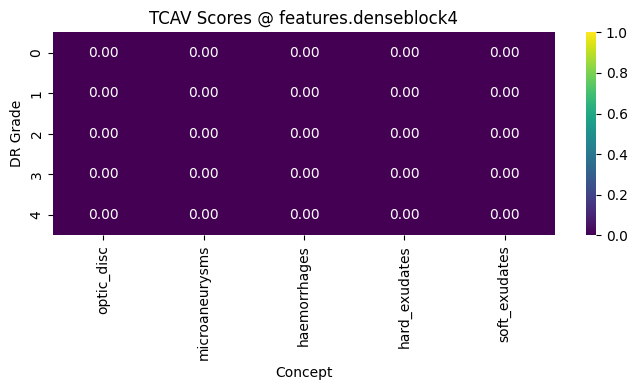

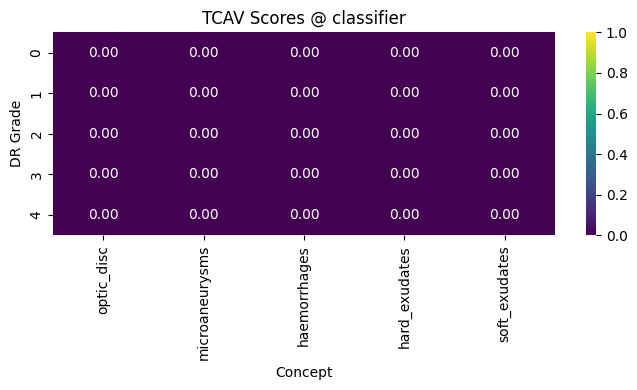

In [68]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 5

LAYERS = ["features.denseblock4", "classifier"]

BATCH_SIZE = 16
NUM_WORKERS = 0

CONCEPT_DIR = "concepts"

CONCEPTS = [
    "optic_disc",
    "microaneurysms",
    "haemorrhages",
    "hard_exudates",
    "soft_exudates"
]

RANDOMS = ["random_1", "random_2"]

TARGET_BASE = os.path.join(CONCEPT_DIR, "target_images")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class ImgFolder(Dataset):
    def __init__(self, folder):
        self.paths = []
        for ext in ("png","jpg","jpeg"):
            self.paths += glob.glob(os.path.join(folder, f"*.{ext}"))
        self.tf = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.tf(img), self.paths[idx]

def make_loader(folder):
    return DataLoader(
        ImgFolder(folder),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

concept_loaders = {c: make_loader(os.path.join(CONCEPT_DIR, c)) for c in CONCEPTS}
random_loaders  = [make_loader(os.path.join(CONCEPT_DIR, r)) for r in RANDOMS]

target_loaders = {
    cls: make_loader(os.path.join(TARGET_BASE, f"class_{cls}"))
    for cls in range(NUM_CLASSES)
}


model = models.densenet121(weights=None)
model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)

ckpt = torch.load("new_saved_models/best_densenet121_model.pth", map_location=DEVICE)
sd = ckpt.get("model", ckpt.get("state_dict", ckpt))
model.load_state_dict(sd, strict=False)
model.to(DEVICE).eval()

activations = []
hook_handle = None

def forward_hook(module, inp, out):
    """Safe GAP or flatten depending on tensor shape."""
    if out.dim() == 4:
        g = F.adaptive_avg_pool2d(out, (1, 1)).view(out.size(0), -1)
    elif out.dim() == 2:
        g = out
    else:
        g = out.view(out.size(0), -1)
    activations.append(g.detach().cpu())

def attach_hook(layer_name):
    global hook_handle
    if hook_handle is not None:
        hook_handle.remove()

    activations.clear()
    found = False

    for name, mod in model.named_modules():
        if name == layer_name:
            hook_handle = mod.register_forward_hook(forward_hook)
            print(f"[hook] attached to '{name}'")
            found = True
            break

    if not found:
        raise ValueError(f"Layer '{layer_name}' not found")


def collect_acts(loader):
    activations.clear()
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            model(xb)

    if len(activations) == 0:
        return None

    return torch.cat(activations, 0).cpu().numpy()

def train_cavs_at(layer_name):
    attach_hook(layer_name)
    cavs = {}

    for concept in CONCEPTS:
        print(f"\nTraining CAV for '{concept}' @ {layer_name}")

        pos = collect_acts(concept_loaders[concept])
        if pos is None or len(pos)==0:
            print(f"No activations for {concept}, skipping.")
            continue

        neg_list = []
        for r in random_loaders:
            neg = collect_acts(r)
            if neg is not None:
                neg_list.append(neg)

        if len(neg_list)==0:
            print("No negative examples found.")
            continue

        neg = np.vstack(neg_list)

        X = np.vstack([pos, neg])
        y = np.array([1]*len(pos) + [0]*len(neg))

        lr = LogisticRegression(max_iter=2000).fit(X, y)
        cavs[concept] = lr.coef_.ravel()

        print(f" → CAV '{concept}' trained. Dim={len(cavs[concept])}")

    return cavs

def tcav_scores_at(layer_name, cavs, loader, target_class):
    attach_hook(layer_name)
    acts = collect_acts(loader)

    if acts is None or len(cavs)==0:
        print("⚠ No activations OR no CAVs available.")
        return {c: 0.0 for c in CONCEPTS}

    scores = {}
    for c, vec in cavs.items():
        scores[c] = float((acts.dot(vec) > 0).mean())

    return scores

all_scores = {
    layer: pd.DataFrame(index=range(NUM_CLASSES), columns=CONCEPTS)
    for layer in LAYERS
}

for layer in LAYERS:
    print(f"\n=== Training CAVs on {layer} ===")
    cav_dict = train_cavs_at(layer)

    for cls in range(NUM_CLASSES):
        print(f"→ TCAV @ {layer}, class {cls}")
        sc = tcav_scores_at(layer, cav_dict, target_loaders[cls], cls)

        for c, v in sc.items():
            all_scores[layer].at[cls, c] = v

for layer, df in all_scores.items():
    plt.figure(figsize=(7,4))
    sns.heatmap(df.astype(float), annot=True, fmt=".2f",
                cmap="viridis", vmin=0, vmax=1)
    plt.title(f"TCAV Scores @ {layer}")
    plt.ylabel("DR Grade")
    plt.xlabel("Concept")
    plt.tight_layout()
    plt.show()

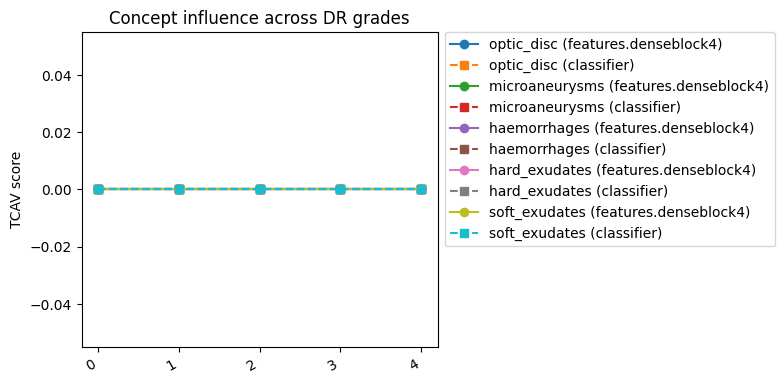

In [69]:
# line plot across grades
plt.figure(figsize=(8,4))
for concept in CONCEPTS:
    plt.plot(df.index,
             all_scores[LAYERS[0]][concept],
             marker="o", label=f"{concept} ({LAYERS[0]})")
    plt.plot(df.index,
             all_scores[LAYERS[1]][concept],
             marker="s", linestyle="--", label=f"{concept} ({LAYERS[1]})")
plt.xticks(rotation=30, ha="right")
plt.ylabel("TCAV score")
plt.title("Concept influence across DR grades")
plt.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.tight_layout()
plt.show()

### Layer-Resolved TCAV Pipeline

Loads a trained DenseNet121 classifier and performs a complete TCAV analysis across multiple internal layers. The workflow includes dataset preparation, activation extraction via forward hooks, CAV training for each concept using logistic regression, and class-wise TCAV scoring across DR severity grades.

In [76]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 5

CONCEPT_DIR = "concepts"

CONCEPTS = [
    "optic_disc",
    "microaneurysms",
    "haemorrhages",
    "hard_exudates",
    "soft_exudates"
]

RANDOMS = ["random_1", "random_2"]
TARGET_BASE = os.path.join(CONCEPT_DIR, "target_images")

GRADE_NAMES = {
    0: "No DR",
    1: "Mild NPDR",
    2: "Moderate NPDR",
    3: "Severe NPDR",
    4: "PDR"
}


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class ImgFolder(Dataset):
    def __init__(self, folder):
        self.paths = []
        for ext in ("png", "jpg", "jpeg","tif"):
            self.paths += glob.glob(os.path.join(folder, f"*.{ext}"))
        self.tf = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.tf(img), self.paths[idx]


def make_loader(folder):
    return DataLoader(
        ImgFolder(folder),
        batch_size=16,
        shuffle=False,
        num_workers=0
    )


concept_loaders = {c: make_loader(os.path.join(CONCEPT_DIR, c)) for c in CONCEPTS}
random_loaders = [make_loader(os.path.join(CONCEPT_DIR, r)) for r in RANDOMS]

target_loaders = {
    g: make_loader(os.path.join(TARGET_BASE, f"class_{g}"))
    for g in range(NUM_CLASSES)
}

def load_model(path="new_saved_models/best_densenet121_model.pth"):
    model = models.densenet121(weights=None)
    model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)

    ckpt = torch.load(path, map_location=DEVICE)
    sd = ckpt.get("model", ckpt.get("state_dict", ckpt))
    model.load_state_dict(sd, strict=False)
    return model.to(DEVICE).eval()

model = load_model()


def find_last_child(prefix):
    names = [n for n, _ in model.named_modules() if n.startswith(prefix)]
    return sorted(names, key=lambda x: len(x))[-1]

LAYER_D4 = find_last_child("features.denseblock4")
LAYER_N5 = "features.norm5"
LAYER_CLS = "classifier"

LAYERS = [LAYER_D4, LAYER_N5, LAYER_CLS]

print("\nResolved layers:", LAYERS)

_acts = []
_hook = None

def forward_hook(module, inp, out):
    if out.ndim == 4:
        out = F.adaptive_avg_pool2d(out, (1,1)).view(out.size(0), -1)
    else:
        out = out.view(out.size(0), -1)
    _acts.append(out.detach().cpu())

def attach_hook(layer):
    global _hook
    if _hook is not None:
        _hook.remove()

    _acts.clear()
    for name, submod in model.named_modules():
        if name == layer:
            _hook = submod.register_forward_hook(forward_hook)
            print(f"[hook] attached → {name}")
            return
    raise ValueError(f"Layer '{layer}' not found")

def collect_acts(loader):
    _acts.clear()
    with torch.no_grad():
        for xb, _ in loader:
            model(xb.to(DEVICE))

    if len(_acts) == 0:
        return None

    return torch.cat(_acts, dim=0).numpy()


def train_cavs(layer):
    attach_hook(layer)
    cavs = {}

    for concept in CONCEPTS:
        pos = collect_acts(concept_loaders[concept])
        if pos is None or len(pos)==0:
            print(f"⚠ No activations for {concept}, skipping")
            continue

        neg_list = [collect_acts(r) for r in random_loaders]
        neg_list = [n for n in neg_list if n is not None]

        if len(neg_list) == 0:
            print("⚠ No negative activations found.")
            continue

        neg = np.vstack(neg_list)

        X = np.vstack([pos, neg])
        y = np.array([1]*len(pos) + [0]*len(neg))

        lr = LogisticRegression(max_iter=2000).fit(X, y)
        cavs[concept] = lr.coef_.ravel()

        print(f"   trained CAV [{concept}] @ {layer} → dim={len(cavs[concept])}")

    return cavs

def tcav_scores(layer, cavs, loader):
    attach_hook(layer)
    acts = collect_acts(loader)
    if acts is None:
        return {c: 0.0 for c in cavs}

    scores = {}
    for concept, cav in cavs.items():
        votes = (acts.dot(cav) > 0).mean()
        scores[concept] = float(votes)
    return scores

all_scores = {
    layer: pd.DataFrame(index=[GRADE_NAMES[g] for g in range(NUM_CLASSES)],
                        columns=CONCEPTS, dtype=float)
    for layer in LAYERS
}

for layer in LAYERS:
    print(f"\n=== Training CAVs @ {layer} ===")
    cavs = train_cavs(layer)

    for g in range(NUM_CLASSES):
        print(f" → TCAV @ grade={GRADE_NAMES[g]}")
        sc = tcav_scores(layer, cavs, target_loaders[g])

        for c, v in sc.items():
            all_scores[layer].loc[GRADE_NAMES[g], c] = v


Resolved layers: ['features.denseblock4.denselayer16.conv2', 'features.norm5', 'classifier']

=== Training CAVs @ features.denseblock4.denselayer16.conv2 ===
[hook] attached → features.denseblock4.denselayer16.conv2
   trained CAV [optic_disc] @ features.denseblock4.denselayer16.conv2 → dim=32
   trained CAV [microaneurysms] @ features.denseblock4.denselayer16.conv2 → dim=32
   trained CAV [haemorrhages] @ features.denseblock4.denselayer16.conv2 → dim=32
   trained CAV [hard_exudates] @ features.denseblock4.denselayer16.conv2 → dim=32
   trained CAV [soft_exudates] @ features.denseblock4.denselayer16.conv2 → dim=32
 → TCAV @ grade=No DR
[hook] attached → features.denseblock4.denselayer16.conv2
 → TCAV @ grade=Mild NPDR
[hook] attached → features.denseblock4.denselayer16.conv2
 → TCAV @ grade=Moderate NPDR
[hook] attached → features.denseblock4.denselayer16.conv2
 → TCAV @ grade=Severe NPDR
[hook] attached → features.denseblock4.denselayer16.conv2
 → TCAV @ grade=PDR
[hook] attached → 

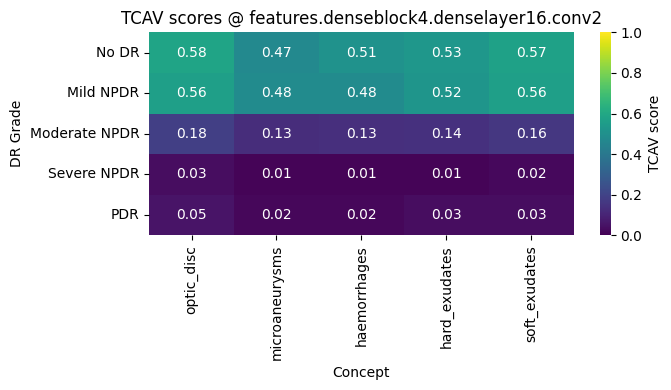

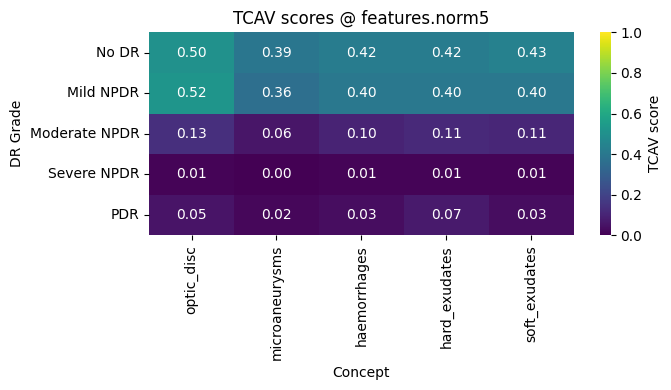

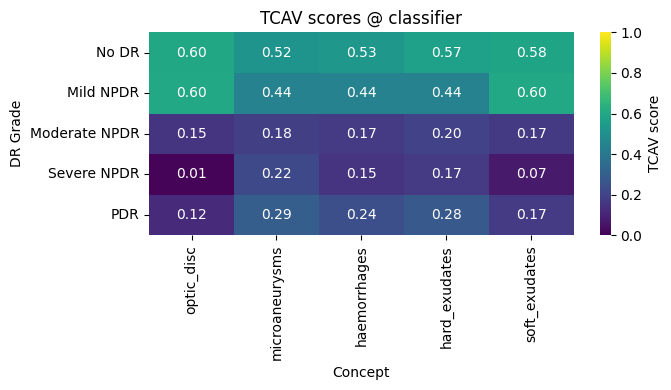

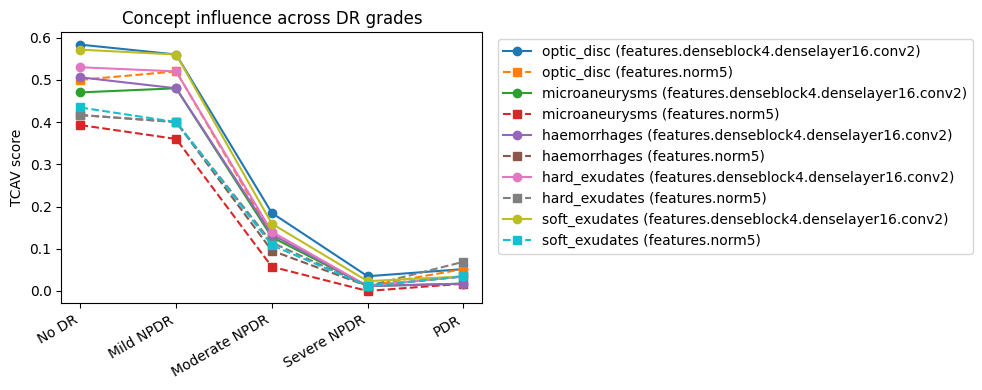

In [80]:
for df in all_scores.values():
    if all(isinstance(i, int) for i in df.index):
        df.index = [GRADE_NAMES[i] for i in df.index]

import seaborn as sns

cmap = "viridis"
vmin, vmax = 0.0, 1.0

for layer, df in all_scores.items():
    plt.figure(figsize=(7, 4))

    sns.heatmap(
        df.astype(float),
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={"label": "TCAV score"}
    )

    plt.title(f"TCAV scores @ {layer}")
    plt.ylabel("DR Grade")
    plt.xlabel("Concept")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 4))

grade_labels = list(next(iter(all_scores.values())).index)
x = np.arange(len(grade_labels))

layers_list = list(all_scores.keys())   # e.g. ['features', 'classifier']

if len(layers_list) < 2:
    raise ValueError("TCAV requires at least two layers to plot comparison!")

layer_A = layers_list[0]
layer_B = layers_list[1]

for concept in CONCEPTS:

    # Solid line for first layer
    plt.plot(
        x,
        all_scores[layer_A][concept].astype(float),
        marker="o",
        linestyle="-",
        label=f"{concept} ({layer_A})"
    )

    # Dashed line for second layer
    plt.plot(
        x,
        all_scores[layer_B][concept].astype(float),
        marker="s",
        linestyle="--",
        label=f"{concept} ({layer_B})"
    )

plt.xticks(x, grade_labels, rotation=30, ha="right")
plt.ylabel("TCAV score")
plt.title("Concept influence across DR grades")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [14]:
print("Full Explainability Suite + Quantitative Evaluation completed successfully.")

Full Explainability Suite + Quantitative Evaluation completed successfully.
